In [20]:
import tqdm as notebook_tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split

MODEL_NAME = "Rostlab/prot_bert" 
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu" # using mps instead of cuda for training on mac
#DEVICE = "cpu"  # use GPU if available, otherwise CPU
print(f"Using device: {DEVICE}")
NUM_CLASSES = 6  # num classes for classification
BATCH_SIZE = 64
EPOCHS = 10
LR = 0.001

Using device: mps


In [21]:
import pandas as pd

records = []  # uniprot_ac, kingdom, type_, sequence, label
with open("/Users/jonas/Desktop/Uni/PBL/data/complete_set_unpartitioned.fasta", "r") as f:
    current_record = None
    for line in f:
        if line.startswith(">"):
            if current_record is not None:
                if current_record["sequence"] is not None and current_record["label"] is not None:
                    # Save the previous record before starting a new one
                    records.append(current_record)
                else:
                    # If the previous record is incomplete, skip it
                    print("Skipping incomplete record:", current_record)
            # Start a new record
            uniprot_ac, kingdom, type_ = line[1:].strip().split("|")
            current_record = {"uniprot_ac": uniprot_ac, "kingdom": kingdom, "type": type_, "sequence": None, "label": None}
        else:
            # Check if the line contains a sequence or a label
            if current_record["sequence"] is None:
                current_record["sequence"] = line.strip()
            elif current_record["label"] is None:
                current_record["label"] = line.strip()
            else:
                # If both sequence and label are already set, skip this line
                print("Skipping extra line in record:", current_record)
    # Save the last record if it's complete
    if current_record is not None:
        if current_record["sequence"] is not None and current_record["label"] is not None:
            records.append(current_record)
        else:
            print("Skipping incomplete record:", current_record)

"""
# Save the DataFrame to a CSV file
df_raw.to_csv("/Users/jonas/Desktop/Uni/PBL/data/complete_set_unpartitioned.csv", index=False)
"""
# Print the number of records
print(f"Total records: {len(records)}")
df_raw = pd.DataFrame(records)
df_raw.head()


Total records: 25693


,uniprot_ac,kingdom,type,sequence,label
0,Q8TF40,EUKARYA,NO_SP,MAPTLFQKLFSKRTGLGAPGRDARDPDCGFSWPLPEFDPSQIRLIV...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
1,Q1ENB6,EUKARYA,NO_SP,MDFTSLETTTFEEVVIALGSNVGNRMNNFKEALRLMKDYGISVTRH...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
2,P36001,EUKARYA,NO_SP,MDDISGRQTLPRINRLLEHVGNPQDSLSILHIAGTNGKETVSKFLT...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
3,P55317,EUKARYA,NO_SP,MLGTVKMEGHETSDWNSYYADTQEAYSSVPVSNMNSGLGSMNSMNT...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
4,P35583,EUKARYA,NO_SP,MLGAVKMEGHEPSDWSSYYAEPEGYSSVSNMNAGLGMNGMNTYMSM...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...


In [22]:
df = df_raw[~df_raw["label"].str.contains("P")]
df.describe()

,uniprot_ac,kingdom,type,sequence,label
count,25580,25580,25580,25580,25580
unique,25580,4,5,24367,1878
top,Q8TF40,EUKARYA,NO_SP,MKLSRRSFMKANAVAAAAAAAGLSVPGVARAVVGQQEAIKWDKAPC...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
freq,1,20423,19036,41,16382


In [23]:
label_map = {'S': 0, 'T': 1, 'L': 2, 'I': 3, 'M': 4, 'O': 5}

df_encoded = df.copy()
df_encoded["label"] = df_encoded["label"].apply(lambda x: [label_map[c] for c in x if c in label_map])
df_encoded = df_encoded[df_encoded["label"].map(len) > 0]  # Remove rows with empty label lists

# make random smaller dataset
#df_encoded = df_encoded.sample(frac=0.4, random_state=42)

sequences = df_encoded["sequence"].tolist()
label_seqs = df_encoded["label"].tolist()

df_encoded.describe()


,uniprot_ac,kingdom,type,sequence,label
count,25580,25580,25580,25580,25580
unique,25580,4,5,24367,1878
top,Q8TF40,EUKARYA,NO_SP,MKLSRRSFMKANAVAAAAAAAGLSVPGVARAVVGQQEAIKWDKAPC...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
freq,1,20423,19036,41,16382


In [24]:
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
encoder = BertModel.from_pretrained(MODEL_NAME)
encoder.to(DEVICE)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-29): 30 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, i

In [25]:
# Stratify by sequence length to avoid ValueError
train_seqs, test_seqs, train_label_seqs, test_label_seqs = train_test_split(
    sequences, label_seqs, test_size=0.3, random_state=42
)

In [26]:
# Load the data 
class SPDataset(Dataset):
    def __init__(self, sequences, label_seqs, label_map):
        self.label_map = label_map
        self.label_seqs = label_seqs
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        # preprocess the sequence (insert spaces between amino acids)
        seq_processed = " ".join(list(seq))
        labels = self.label_seqs[idx]
        # Tokenize the sequence (padding to ensure all sequences are the same length -> 512 tokens) 
        encoded = tokenizer(seq_processed, return_tensors="pt",
                            padding="max_length", truncation=True, max_length=512)
        input_ids = encoded['input_ids'].squeeze(0)
        attention_mask = encoded['attention_mask'].squeeze(0)
        
        # Build a label tensor of the same length as input_ids.
        # For tokens beyond the original sequence length, assign -100 so that loss func ignores them.
        orig_length = len(seq)
        token_labels = []
        
        for i in range(input_ids.size(0)):
            if i == 0 or i > orig_length:  
                token_labels.append(-100)  # ignore padding tokens
            else:
                # Use the already encoded label directly
                token_labels.append(labels[i-1])
        labels_tensor = torch.tensor(token_labels)
        
        return {
            'input_ids': input_ids, # tokenized and padded 
            'attention_mask': attention_mask, # differentiate between padding and non-padding tokens
            'labels': labels_tensor # aligned label tensor
        }

train_dataset = SPDataset(train_seqs, train_label_seqs, label_map)
test_dataset = SPDataset(test_seqs, test_label_seqs, label_map)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchcrf import CRF

class SPCNNClassifier(nn.Module):
    def __init__(self, encoder_model, num_labels):
        super().__init__()
        self.encoder = encoder_model  
        self.dropout = nn.Dropout(0.3)
        hidden_size = self.encoder.config.hidden_size
        # detects local features in the sequence
        self.conv1 = nn.Conv1d(in_channels=hidden_size, out_channels=1024, kernel_size=6, dilation=2, padding=5)
        #self.conv2 = nn.Conv1d(in_channels=1024, out_channels=num_labels, kernel_size=3, dilation=2, padding=2)
        # dense layer
        self.lstm = nn.LSTM(input_size=1024, hidden_size=512, num_layers=1, bidirectional=True, batch_first=True)
        self.classifier = nn.Linear(512 * 2, num_labels)
        self.crf = CRF(num_labels, batch_first=True)



    def forward(self, input_ids, attention_mask, labels=None):
        # Encode with BERT
        encoder_output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = encoder_output.last_hidden_state  # (batch, seq_len, hidden_size)

        #  CNN 1
        x = hidden_states.transpose(1, 2)                # (batch, hidden_size, seq_len)
        x_conv1 = F.relu(self.conv1(x))                  # (batch, 1024, seq_len)

        # Transpose CNN output for LSTM: (batch, seq_len, features)
        x_lstm_input = x_conv1.transpose(1, 2)           # (batch, seq_len, 1024)

        # Apply BiLSTM
        lstm_out, _ = self.lstm(x_lstm_input)            # (batch, seq_len, 1024)

        # Classifier to num_labels
        x_linear = self.classifier(lstm_out)             # (batch, seq_len, num_labels)

        # CNN 2
        # x_conv2 = self.conv2(x_conv1).transpose(1, 2)
        # logits = self.dropout(x_conv2 + x_linear)

        logits = self.dropout(x_linear)                  # (batch, seq_len, num_labels)

        if labels is not None:
            loss = -self.crf(logits, labels, mask=attention_mask.bool(), reduction='mean')
            return loss
        else:
            predictions = self.crf.decode(logits, mask=attention_mask.bool())
            return predictions



In [28]:
from transformers import get_linear_schedule_with_warmup

# Initialize the model
model = SPCNNClassifier(encoder, NUM_CLASSES).to(DEVICE)

# optimizer 
optimizer = torch.optim.Adam([
    {"params": model.encoder.encoder.layer[-4:].parameters(), "lr": 5e-6},
    {"params": model.conv1.parameters(), "lr": 1e-3},
    #{"params": model.conv2.parameters(), "lr": 1e-3},
    {"params": model.classifier.parameters(), "lr": 1e-3},
    {"params": model.crf.parameters(), "lr": 1e-3},
])

total_steps = len(train_loader) * EPOCHS
# scheduler for learning rate
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)
# Counter({'I': 1204001, 'O': 362643, 'S': 85526, 'M': 74445, 'L': 46065, 'T': 22272, 'P': 951})
class_counts = [1204001, 85526, 22272, 46865, 74445, 362643]  # Count for each class (I, S, T, L, M, O)
# hopefully deals with the class imbalance
weights = torch.tensor([1.0 / count for count in class_counts], device=DEVICE)

# loss function that ignores the padding tokens (-100)
loss_fn = nn.CrossEntropyLoss(weight=weights, ignore_index=-100)

In [10]:
# Compute sequence-level accuracy, skipping -100 (ignored) positions
def sequence_level_accuracy(preds_flat, labels_flat, test_label_seqs):
    # reconstruct the sequences from the flat predictions
    seq_lengths = [len(seq) for seq in test_label_seqs]
    preds_seq = []
    labels_seq = []
    idx = 0
    for l in seq_lengths:
        preds_seq.append(preds_flat[idx:idx+l])
        labels_seq.append(labels_flat[idx:idx+l])
        idx += l

    # check if the valid predictions match the labels
    correct = 0
    for pred, label in zip(preds_seq, labels_seq):
        is_valid = [l != -100 for l in label]
        valid_preds = [p for p, valid in zip(pred, is_valid) if valid]
        valid_labels = [l for l, valid in zip(label, is_valid) if valid]
        if valid_preds == valid_labels:
            correct += 1

    total = len(seq_lengths)
    return correct / total if total > 0 else 0.0


In [11]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import matthews_corrcoef

def evaluate_model(model, data_loader, loss_fn, test_label_seqs):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    for batch in tqdm(data_loader, desc="Evaluation", leave=False):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits.reshape(-1, NUM_CLASSES), labels.reshape(-1))
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=-1)
        # Flatten and filter out padding tokens (-100)
        preds_flat = preds.view(-1)
        labels_flat = labels.view(-1)
        valid_idx = labels_flat != -100
        all_preds.extend(preds_flat[valid_idx].cpu().numpy())
        all_labels.extend(labels_flat[valid_idx].cpu().numpy())
    avg_loss = total_loss / len(data_loader)
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=list(label_map.keys()))
    
    try:
        mcc = matthews_corrcoef(all_labels, all_preds)
    except ImportError:
        mcc = None

    print("Classification Report:")
    print(report)
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Token-level Accuracy: {acc:.4f}")
    print(f"Matthews Correlation Coefficient (MCC): {mcc if mcc is not None else 'N/A'}")
    
    # Compute sequence-level accuracy if the function is defined
    try:
        seq_acc_val = sequence_level_accuracy(all_preds, all_labels, test_label_seqs)
        print(f"Sequence Level Accuracy: {seq_acc_val:.4f}")
    except Exception as e:
        seq_acc_val = None
        print("Sequence Level Accuracy could not be computed:", e)
    
    return avg_loss, acc, mcc, seq_acc_val


In [12]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from tqdm import tqdm

writer = SummaryWriter(log_dir="/Users/jonas/Desktop/Uni/PBL/logs/prot_bert_linear_classifier_v3")

for param in model.encoder.parameters():
    param.requires_grad = False # if this is true then mps runs out of memory

for epoch in range(EPOCHS):

    model.train()

    # Gradually unfreeze only a subset of encoder layers for efficiency
    if epoch == 4:
        # Unfreeze only the last encoder layer
        try:
            for param in model.encoder.encoder.layer[-4:].parameters():
                param.requires_grad = True
        except Exception as e:
            print("Error unfreezing parameters in Epoch 4:", e)
            continue
    elif epoch == 7:
        try:
            for param in model.encoder.parameters():            
                param.requires_grad = True
        except Exception as e:
            print("Error unfreezing parameters in Epoch 7:", e)
            continue

    # progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch")
    total_loss = 0 # total epoch loss

    for batch in pbar:
        try:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            token_labels = batch['labels'].to(DEVICE)

            optimizer.zero_grad()  # resets gradients

            loss = model(input_ids, attention_mask, token_labels)  # forward pass (loss calculated in the foward method)
            loss.backward()  # backpropagation
            optimizer.step()  # update weights with optimizer
            scheduler.step() # update learning rate

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
        except Exception as e:
            print("Error during training:", e)
            model.DEVICE = "cpu"  # fallback to CPU
            continue

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_train_loss:.4f}")
    writer.add_scalar("Loss/train", avg_train_loss, epoch)
    
 



Epoch 1/10: 100%|██████████| 280/280 [41:39<00:00,  8.93s/batch, loss=36.8]


Epoch 1, Loss: 57.2500


Epoch 2/10: 100%|██████████| 280/280 [42:56<00:00,  9.20s/batch, loss=21.7]


Epoch 2, Loss: 31.3408


Epoch 3/10: 100%|██████████| 280/280 [40:46<00:00,  8.74s/batch, loss=18.4]


Epoch 3, Loss: 23.9139


Epoch 4/10: 100%|██████████| 280/280 [40:47<00:00,  8.74s/batch, loss=14.8]


Epoch 4, Loss: 19.2143


Epoch 5/10:   0%|          | 1/280 [00:09<43:46,  9.41s/batch]

Error during training: MPS backend out of memory (MPS allocated: 15.18 GB, other allocations: 2.00 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   1%|          | 2/280 [00:25<1:01:31, 13.28s/batch]

Error during training: MPS backend out of memory (MPS allocated: 15.93 GB, other allocations: 2.03 GB, max allowed: 18.13 GB). Tried to allocate 512.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   1%|          | 3/280 [00:40<1:05:36, 14.21s/batch]

Error during training: MPS backend out of memory (MPS allocated: 16.05 GB, other allocations: 2.00 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   1%|▏         | 4/280 [00:55<1:05:36, 14.26s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.93 GB, other allocations: 3.03 GB, max allowed: 18.13 GB). Tried to allocate 512.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   2%|▏         | 5/280 [01:08<1:04:06, 13.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.43 GB, other allocations: 3.00 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   2%|▏         | 6/280 [01:22<1:03:07, 13.82s/batch]

Error during training: MPS backend out of memory (MPS allocated: 14.93 GB, other allocations: 3.00 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   2%|▎         | 7/280 [01:34<1:00:07, 13.21s/batch]

Error during training: MPS backend out of memory (MPS allocated: 15.05 GB, other allocations: 3.00 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   3%|▎         | 8/280 [01:47<1:00:57, 13.45s/batch]

Error during training: MPS backend out of memory (MPS allocated: 15.80 GB, other allocations: 2.63 GB, max allowed: 18.13 GB). Tried to allocate 768.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   3%|▎         | 9/280 [01:58<56:52, 12.59s/batch]  

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   4%|▎         | 10/280 [02:10<55:35, 12.36s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   4%|▍         | 11/280 [02:22<54:36, 12.18s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   4%|▍         | 12/280 [02:32<52:15, 11.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   5%|▍         | 13/280 [02:42<49:50, 11.20s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.17 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   5%|▌         | 14/280 [02:53<48:39, 10.97s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.17 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   5%|▌         | 15/280 [03:04<48:42, 11.03s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   6%|▌         | 16/280 [03:16<49:50, 11.33s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.17 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   6%|▌         | 17/280 [03:31<54:21, 12.40s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   6%|▋         | 18/280 [03:45<55:57, 12.81s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   7%|▋         | 19/280 [03:55<52:28, 12.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   7%|▋         | 20/280 [04:07<51:44, 11.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.17 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   8%|▊         | 21/280 [04:18<50:07, 11.61s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   8%|▊         | 22/280 [04:35<57:21, 13.34s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   8%|▊         | 23/280 [04:46<54:27, 12.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   9%|▊         | 24/280 [05:04<1:00:19, 14.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   9%|▉         | 25/280 [05:16<58:08, 13.68s/batch]  

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:   9%|▉         | 26/280 [05:31<58:52, 13.91s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  10%|▉         | 27/280 [05:43<56:54, 13.49s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.17 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  10%|█         | 28/280 [05:56<56:09, 13.37s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  10%|█         | 29/280 [06:12<58:47, 14.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  11%|█         | 30/280 [06:25<57:48, 13.87s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  11%|█         | 31/280 [06:37<54:57, 13.24s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  11%|█▏        | 32/280 [06:48<51:23, 12.43s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  12%|█▏        | 33/280 [06:59<49:09, 11.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  12%|█▏        | 34/280 [07:12<51:02, 12.45s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  12%|█▎        | 35/280 [07:27<53:42, 13.15s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  13%|█▎        | 36/280 [07:40<53:05, 13.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  13%|█▎        | 37/280 [07:57<58:03, 14.34s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  14%|█▎        | 38/280 [08:12<57:58, 14.37s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  14%|█▍        | 39/280 [08:23<54:47, 13.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  14%|█▍        | 40/280 [08:36<52:41, 13.17s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  15%|█▍        | 41/280 [08:50<54:24, 13.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  15%|█▌        | 42/280 [09:10<1:01:15, 15.44s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  15%|█▌        | 43/280 [09:26<1:02:05, 15.72s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  16%|█▌        | 44/280 [09:44<1:03:38, 16.18s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  16%|█▌        | 45/280 [10:02<1:05:41, 16.77s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  16%|█▋        | 46/280 [10:14<1:00:08, 15.42s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  17%|█▋        | 47/280 [10:27<56:34, 14.57s/batch]  

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  17%|█▋        | 48/280 [10:39<54:21, 14.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  18%|█▊        | 49/280 [10:51<50:42, 13.17s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  18%|█▊        | 50/280 [11:06<52:51, 13.79s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  18%|█▊        | 51/280 [11:19<52:22, 13.72s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  19%|█▊        | 52/280 [11:35<54:25, 14.32s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  19%|█▉        | 53/280 [11:49<53:12, 14.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  19%|█▉        | 54/280 [12:03<53:51, 14.30s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  20%|█▉        | 55/280 [12:20<56:02, 14.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  20%|██        | 56/280 [12:35<55:43, 14.93s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  20%|██        | 57/280 [12:50<55:52, 15.03s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  21%|██        | 58/280 [13:03<53:29, 14.46s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.17 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  21%|██        | 59/280 [13:17<52:35, 14.28s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  21%|██▏       | 60/280 [13:33<53:52, 14.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  22%|██▏       | 61/280 [13:44<50:15, 13.77s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  22%|██▏       | 62/280 [13:58<49:56, 13.75s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  22%|██▎       | 63/280 [14:11<49:26, 13.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  23%|██▎       | 64/280 [14:29<53:32, 14.87s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  23%|██▎       | 65/280 [14:42<51:29, 14.37s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  24%|██▎       | 66/280 [14:54<48:08, 13.50s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.17 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  24%|██▍       | 67/280 [15:05<45:58, 12.95s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  24%|██▍       | 68/280 [15:19<46:26, 13.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  25%|██▍       | 69/280 [15:31<45:09, 12.84s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  25%|██▌       | 70/280 [15:45<45:58, 13.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  25%|██▌       | 71/280 [15:57<44:34, 12.80s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  26%|██▌       | 72/280 [16:07<41:52, 12.08s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  26%|██▌       | 73/280 [16:23<44:56, 13.03s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  26%|██▋       | 74/280 [16:39<47:55, 13.96s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  27%|██▋       | 75/280 [16:53<48:17, 14.13s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  27%|██▋       | 76/280 [17:06<46:23, 13.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  28%|██▊       | 77/280 [17:18<44:29, 13.15s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  28%|██▊       | 78/280 [17:36<49:29, 14.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  28%|██▊       | 79/280 [17:49<47:05, 14.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  29%|██▊       | 80/280 [18:02<45:57, 13.79s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  29%|██▉       | 81/280 [18:17<46:35, 14.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  29%|██▉       | 82/280 [18:32<47:22, 14.35s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  30%|██▉       | 83/280 [18:45<45:44, 13.93s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  30%|███       | 84/280 [18:57<44:07, 13.51s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  30%|███       | 85/280 [19:10<42:59, 13.23s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  31%|███       | 86/280 [19:25<45:03, 13.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  31%|███       | 87/280 [19:38<44:03, 13.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  31%|███▏      | 88/280 [19:50<41:58, 13.12s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  32%|███▏      | 89/280 [20:10<48:23, 15.20s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  32%|███▏      | 90/280 [20:29<51:49, 16.37s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  32%|███▎      | 91/280 [20:46<52:13, 16.58s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  33%|███▎      | 92/280 [21:02<51:29, 16.43s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  33%|███▎      | 93/280 [21:17<49:54, 16.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  34%|███▎      | 94/280 [21:35<51:14, 16.53s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  34%|███▍      | 95/280 [21:50<49:43, 16.12s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  34%|███▍      | 96/280 [22:03<45:59, 15.00s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  35%|███▍      | 97/280 [22:19<46:56, 15.39s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  35%|███▌      | 98/280 [22:33<45:38, 15.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  35%|███▌      | 99/280 [22:48<45:11, 14.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  36%|███▌      | 100/280 [23:02<43:35, 14.53s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  36%|███▌      | 101/280 [23:13<40:55, 13.72s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  36%|███▋      | 102/280 [23:24<38:11, 12.88s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.17 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  37%|███▋      | 103/280 [23:36<37:04, 12.57s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  37%|███▋      | 104/280 [23:52<39:27, 13.45s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  38%|███▊      | 105/280 [24:05<38:56, 13.35s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  38%|███▊      | 106/280 [24:15<35:58, 12.40s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  38%|███▊      | 107/280 [24:24<32:55, 11.42s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  39%|███▊      | 108/280 [24:39<35:45, 12.48s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  39%|███▉      | 109/280 [24:52<35:34, 12.48s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  39%|███▉      | 110/280 [25:06<37:04, 13.08s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  40%|███▉      | 111/280 [25:18<36:13, 12.86s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  40%|████      | 112/280 [25:32<36:13, 12.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  40%|████      | 113/280 [25:44<36:00, 12.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  41%|████      | 114/280 [25:59<37:25, 13.53s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  41%|████      | 115/280 [26:14<37:55, 13.79s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  41%|████▏     | 116/280 [26:29<39:11, 14.34s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  42%|████▏     | 117/280 [26:41<36:22, 13.39s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.17 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  42%|████▏     | 118/280 [26:54<35:55, 13.31s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  42%|████▎     | 119/280 [27:14<41:20, 15.41s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  43%|████▎     | 120/280 [27:25<37:54, 14.22s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.17 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  43%|████▎     | 121/280 [27:38<36:42, 13.85s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  44%|████▎     | 122/280 [27:51<35:04, 13.32s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  44%|████▍     | 123/280 [28:10<39:41, 15.17s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  44%|████▍     | 124/280 [28:23<38:08, 14.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  45%|████▍     | 125/280 [28:42<41:07, 15.92s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  45%|████▌     | 126/280 [28:56<39:00, 15.20s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  45%|████▌     | 127/280 [29:11<38:58, 15.29s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  46%|████▌     | 128/280 [29:26<38:20, 15.13s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  46%|████▌     | 129/280 [29:39<36:41, 14.58s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  46%|████▋     | 130/280 [29:56<37:53, 15.16s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  47%|████▋     | 131/280 [30:11<37:35, 15.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  47%|████▋     | 132/280 [30:25<36:29, 14.80s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  48%|████▊     | 133/280 [30:39<35:56, 14.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  48%|████▊     | 134/280 [30:51<33:13, 13.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.17 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  48%|████▊     | 135/280 [31:05<33:10, 13.73s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  49%|████▊     | 136/280 [31:19<33:15, 13.86s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  49%|████▉     | 137/280 [31:32<32:19, 13.56s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  49%|████▉     | 138/280 [31:45<32:01, 13.53s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.92 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  50%|████▉     | 139/280 [31:56<29:56, 12.74s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  50%|█████     | 140/280 [32:08<29:05, 12.47s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  50%|█████     | 141/280 [32:19<27:54, 12.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  51%|█████     | 142/280 [32:29<26:38, 11.59s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  51%|█████     | 143/280 [32:42<27:22, 11.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  51%|█████▏    | 144/280 [32:58<29:27, 12.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  52%|█████▏    | 145/280 [33:11<29:30, 13.11s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  52%|█████▏    | 146/280 [33:21<27:19, 12.24s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  52%|█████▎    | 147/280 [33:36<29:01, 13.09s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  53%|█████▎    | 148/280 [33:48<27:52, 12.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  53%|█████▎    | 149/280 [34:04<30:01, 13.75s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  54%|█████▎    | 150/280 [34:15<28:07, 12.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  54%|█████▍    | 151/280 [34:30<28:40, 13.33s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  54%|█████▍    | 152/280 [34:43<28:21, 13.30s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  55%|█████▍    | 153/280 [34:59<30:03, 14.20s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  55%|█████▌    | 154/280 [35:11<28:38, 13.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.17 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  55%|█████▌    | 155/280 [35:23<26:52, 12.90s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  56%|█████▌    | 156/280 [35:36<27:06, 13.11s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  56%|█████▌    | 157/280 [35:53<29:03, 14.17s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  56%|█████▋    | 158/280 [36:08<29:29, 14.50s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  57%|█████▋    | 159/280 [36:27<31:36, 15.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  57%|█████▋    | 160/280 [36:41<30:43, 15.36s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  57%|█████▊    | 161/280 [36:55<29:26, 14.84s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.17 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  58%|█████▊    | 162/280 [37:09<28:41, 14.59s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  58%|█████▊    | 163/280 [37:22<27:33, 14.13s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  59%|█████▊    | 164/280 [37:33<25:36, 13.25s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  59%|█████▉    | 165/280 [37:47<25:56, 13.54s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  59%|█████▉    | 166/280 [38:00<25:14, 13.29s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.17 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  60%|█████▉    | 167/280 [38:12<24:10, 12.83s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  60%|██████    | 168/280 [38:23<23:17, 12.48s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  60%|██████    | 169/280 [38:35<22:27, 12.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  61%|██████    | 170/280 [38:51<24:35, 13.42s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  61%|██████    | 171/280 [39:03<23:38, 13.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  61%|██████▏   | 172/280 [39:13<21:41, 12.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  62%|██████▏   | 173/280 [39:25<21:26, 12.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  62%|██████▏   | 174/280 [39:42<23:51, 13.50s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  62%|██████▎   | 175/280 [39:56<23:41, 13.54s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  63%|██████▎   | 176/280 [40:08<22:40, 13.08s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  63%|██████▎   | 177/280 [40:22<23:01, 13.41s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  64%|██████▎   | 178/280 [40:38<24:07, 14.19s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  64%|██████▍   | 179/280 [40:52<23:51, 14.17s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  64%|██████▍   | 180/280 [41:06<23:31, 14.12s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  65%|██████▍   | 181/280 [41:19<22:56, 13.90s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  65%|██████▌   | 182/280 [41:31<21:38, 13.25s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.17 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  65%|██████▌   | 183/280 [41:45<21:34, 13.35s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  66%|██████▌   | 184/280 [42:00<22:18, 13.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  66%|██████▌   | 185/280 [42:14<22:20, 14.11s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  66%|██████▋   | 186/280 [42:30<22:50, 14.58s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  67%|██████▋   | 187/280 [42:43<21:58, 14.17s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.17 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  67%|██████▋   | 188/280 [42:55<20:29, 13.36s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  68%|██████▊   | 189/280 [43:11<21:30, 14.18s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.92 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  68%|██████▊   | 190/280 [43:25<21:25, 14.28s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  68%|██████▊   | 191/280 [43:36<19:43, 13.30s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  69%|██████▊   | 192/280 [43:48<18:57, 12.93s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  69%|██████▉   | 193/280 [44:05<20:21, 14.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  69%|██████▉   | 194/280 [44:22<21:21, 14.90s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  70%|██████▉   | 195/280 [44:35<20:15, 14.30s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  70%|███████   | 196/280 [44:53<21:38, 15.45s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  70%|███████   | 197/280 [45:05<19:49, 14.33s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.17 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  71%|███████   | 198/280 [45:20<20:00, 14.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  71%|███████   | 199/280 [45:34<19:16, 14.28s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  71%|███████▏  | 200/280 [45:49<19:30, 14.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  72%|███████▏  | 201/280 [46:04<19:21, 14.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  72%|███████▏  | 202/280 [46:20<19:41, 15.15s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  72%|███████▎  | 203/280 [46:33<18:24, 14.34s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  73%|███████▎  | 204/280 [46:45<17:28, 13.79s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  73%|███████▎  | 205/280 [47:03<18:55, 15.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  74%|███████▎  | 206/280 [47:14<17:00, 13.79s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  74%|███████▍  | 207/280 [47:25<15:46, 12.96s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  74%|███████▍  | 208/280 [47:40<16:14, 13.53s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  75%|███████▍  | 209/280 [47:56<16:50, 14.23s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  75%|███████▌  | 210/280 [48:12<17:08, 14.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  75%|███████▌  | 211/280 [48:26<16:59, 14.77s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  76%|███████▌  | 212/280 [48:38<15:48, 13.95s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  76%|███████▌  | 213/280 [48:55<16:32, 14.82s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  76%|███████▋  | 214/280 [49:08<15:42, 14.28s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  77%|███████▋  | 215/280 [49:27<16:56, 15.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  77%|███████▋  | 216/280 [49:40<15:42, 14.73s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  78%|███████▊  | 217/280 [49:53<15:06, 14.38s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  78%|███████▊  | 218/280 [50:08<14:57, 14.48s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.17 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  78%|███████▊  | 219/280 [50:19<13:37, 13.41s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  79%|███████▊  | 220/280 [50:31<13:08, 13.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  79%|███████▉  | 221/280 [50:43<12:24, 12.61s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  79%|███████▉  | 222/280 [50:56<12:15, 12.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.17 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  80%|███████▉  | 223/280 [51:10<12:26, 13.10s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  80%|████████  | 224/280 [51:24<12:27, 13.34s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  80%|████████  | 225/280 [51:38<12:26, 13.57s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  81%|████████  | 226/280 [51:54<12:53, 14.32s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  81%|████████  | 227/280 [52:06<11:56, 13.52s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  81%|████████▏ | 228/280 [52:19<11:46, 13.58s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  82%|████████▏ | 229/280 [52:34<11:47, 13.87s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  82%|████████▏ | 230/280 [52:51<12:24, 14.88s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  82%|████████▎ | 231/280 [53:07<12:18, 15.07s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  83%|████████▎ | 232/280 [53:22<12:13, 15.29s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  83%|████████▎ | 233/280 [53:37<11:51, 15.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  84%|████████▎ | 234/280 [53:51<11:22, 14.84s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  84%|████████▍ | 235/280 [54:04<10:41, 14.27s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  84%|████████▍ | 236/280 [54:18<10:22, 14.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  85%|████████▍ | 237/280 [54:32<10:02, 14.00s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  85%|████████▌ | 238/280 [54:46<09:45, 13.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  85%|████████▌ | 239/280 [55:01<09:55, 14.53s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  86%|████████▌ | 240/280 [55:15<09:26, 14.17s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  86%|████████▌ | 241/280 [55:29<09:10, 14.12s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  86%|████████▋ | 242/280 [55:43<08:54, 14.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  87%|████████▋ | 243/280 [55:57<08:40, 14.07s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  87%|████████▋ | 244/280 [56:10<08:16, 13.79s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  88%|████████▊ | 245/280 [56:22<07:47, 13.37s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  88%|████████▊ | 246/280 [56:38<07:53, 13.93s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  88%|████████▊ | 247/280 [56:51<07:39, 13.92s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  89%|████████▊ | 248/280 [57:06<07:28, 14.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  89%|████████▉ | 249/280 [57:18<07:01, 13.60s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.42 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  89%|████████▉ | 250/280 [57:31<06:44, 13.47s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  90%|████████▉ | 251/280 [57:45<06:27, 13.37s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  90%|█████████ | 252/280 [58:02<06:52, 14.73s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  90%|█████████ | 253/280 [58:15<06:19, 14.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  91%|█████████ | 254/280 [58:30<06:15, 14.45s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  91%|█████████ | 255/280 [58:47<06:19, 15.17s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  91%|█████████▏| 256/280 [58:59<05:39, 14.15s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  92%|█████████▏| 257/280 [59:14<05:33, 14.49s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  92%|█████████▏| 258/280 [59:33<05:45, 15.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  92%|█████████▎| 259/280 [59:45<05:10, 14.78s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  93%|█████████▎| 260/280 [59:58<04:40, 14.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  93%|█████████▎| 261/280 [1:00:12<04:31, 14.27s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  94%|█████████▎| 262/280 [1:00:24<04:01, 13.42s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.17 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  94%|█████████▍| 263/280 [1:00:34<03:32, 12.51s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  94%|█████████▍| 264/280 [1:00:47<03:21, 12.59s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  95%|█████████▍| 265/280 [1:00:59<03:04, 12.31s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  95%|█████████▌| 266/280 [1:01:13<03:00, 12.89s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  95%|█████████▌| 267/280 [1:01:26<02:49, 13.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  96%|█████████▌| 268/280 [1:01:38<02:33, 12.75s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  96%|█████████▌| 269/280 [1:01:50<02:16, 12.44s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  96%|█████████▋| 270/280 [1:02:04<02:07, 12.74s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  97%|█████████▋| 271/280 [1:02:17<01:56, 12.95s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  97%|█████████▋| 272/280 [1:02:31<01:44, 13.11s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  98%|█████████▊| 273/280 [1:02:43<01:31, 13.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  98%|█████████▊| 274/280 [1:02:54<01:14, 12.43s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.67 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  98%|█████████▊| 275/280 [1:03:06<01:00, 12.07s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  99%|█████████▊| 276/280 [1:03:19<00:50, 12.54s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  99%|█████████▉| 277/280 [1:03:32<00:37, 12.51s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.30 GB, other allocations: 4.14 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10:  99%|█████████▉| 278/280 [1:03:45<00:25, 12.77s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10: 100%|█████████▉| 279/280 [1:04:01<00:13, 13.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.80 GB, other allocations: 4.13 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 5/10: 100%|██████████| 280/280 [1:04:19<00:00, 13.78s/batch, loss=13.4]


Epoch 5, Loss: 0.0478


Epoch 6/10:   0%|          | 1/280 [00:17<1:21:42, 17.57s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   1%|          | 2/280 [00:27<1:00:49, 13.13s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   1%|          | 3/280 [00:35<50:25, 10.92s/batch]  

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   1%|▏         | 4/280 [00:45<48:26, 10.53s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   2%|▏         | 5/280 [00:56<47:50, 10.44s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   2%|▏         | 6/280 [01:07<48:42, 10.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   2%|▎         | 7/280 [01:17<47:36, 10.46s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   3%|▎         | 8/280 [01:28<48:00, 10.59s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   3%|▎         | 9/280 [01:38<48:15, 10.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   4%|▎         | 10/280 [01:48<46:55, 10.43s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   4%|▍         | 11/280 [01:57<44:53, 10.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   4%|▍         | 12/280 [02:07<43:36,  9.76s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   5%|▍         | 13/280 [02:17<43:37,  9.80s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   5%|▌         | 14/280 [02:26<43:03,  9.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   5%|▌         | 15/280 [02:35<42:32,  9.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   6%|▌         | 16/280 [02:46<43:29,  9.88s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   6%|▌         | 17/280 [02:55<42:35,  9.72s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   6%|▋         | 18/280 [03:06<43:26,  9.95s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   7%|▋         | 19/280 [03:17<44:56, 10.33s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   7%|▋         | 20/280 [03:27<44:08, 10.19s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   8%|▊         | 21/280 [03:36<42:27,  9.84s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   8%|▊         | 22/280 [03:45<41:45,  9.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   8%|▊         | 23/280 [03:55<41:44,  9.74s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   9%|▊         | 24/280 [04:05<41:34,  9.74s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   9%|▉         | 25/280 [04:16<43:14, 10.17s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:   9%|▉         | 26/280 [04:24<40:43,  9.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  10%|▉         | 27/280 [04:34<40:12,  9.53s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  10%|█         | 28/280 [04:45<42:08, 10.03s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  10%|█         | 29/280 [04:55<41:31,  9.93s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  11%|█         | 30/280 [05:04<40:23,  9.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  11%|█         | 31/280 [05:15<41:42, 10.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  11%|█▏        | 32/280 [05:24<41:06,  9.95s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  12%|█▏        | 33/280 [05:34<40:45,  9.90s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  12%|█▏        | 34/280 [05:43<39:46,  9.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  12%|█▎        | 35/280 [05:52<38:45,  9.49s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  13%|█▎        | 36/280 [06:02<38:14,  9.41s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  13%|█▎        | 37/280 [06:12<39:05,  9.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  14%|█▎        | 38/280 [06:21<37:59,  9.42s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  14%|█▍        | 39/280 [06:32<40:07,  9.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  14%|█▍        | 40/280 [06:41<38:16,  9.57s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  15%|█▍        | 41/280 [06:50<38:03,  9.55s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  15%|█▌        | 42/280 [07:00<37:52,  9.55s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  15%|█▌        | 43/280 [07:08<36:45,  9.30s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  16%|█▌        | 44/280 [07:18<36:48,  9.36s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  16%|█▌        | 45/280 [07:29<38:38,  9.87s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  16%|█▋        | 46/280 [07:38<37:49,  9.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  17%|█▋        | 47/280 [07:47<36:47,  9.47s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  17%|█▋        | 48/280 [07:56<35:27,  9.17s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  18%|█▊        | 49/280 [08:05<35:41,  9.27s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  18%|█▊        | 50/280 [08:15<36:12,  9.45s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  18%|█▊        | 51/280 [08:25<36:15,  9.50s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  19%|█▊        | 52/280 [08:34<36:03,  9.49s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  19%|█▉        | 53/280 [08:43<35:46,  9.46s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  19%|█▉        | 54/280 [08:52<34:25,  9.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  20%|█▉        | 55/280 [09:00<33:38,  8.97s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  20%|██        | 56/280 [09:09<32:59,  8.84s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  20%|██        | 57/280 [09:18<33:13,  8.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  21%|██        | 58/280 [09:27<33:26,  9.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  21%|██        | 59/280 [09:36<32:30,  8.83s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  21%|██▏       | 60/280 [09:46<34:03,  9.29s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  22%|██▏       | 61/280 [09:55<33:43,  9.24s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  22%|██▏       | 62/280 [10:04<33:03,  9.10s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  22%|██▎       | 63/280 [10:13<32:29,  8.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  23%|██▎       | 64/280 [10:22<32:42,  9.09s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  23%|██▎       | 65/280 [10:32<33:39,  9.39s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  24%|██▎       | 66/280 [10:43<35:10,  9.86s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  24%|██▍       | 67/280 [10:52<33:48,  9.52s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  24%|██▍       | 68/280 [11:03<34:55,  9.89s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  25%|██▍       | 69/280 [11:13<35:36, 10.13s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  25%|██▌       | 70/280 [11:23<34:58,  9.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  25%|██▌       | 71/280 [11:33<34:43,  9.97s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  26%|██▌       | 72/280 [11:44<35:45, 10.31s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  26%|██▌       | 73/280 [11:53<34:38, 10.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  26%|██▋       | 74/280 [12:04<35:06, 10.22s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  27%|██▋       | 75/280 [12:14<34:23, 10.07s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  27%|██▋       | 76/280 [12:22<32:47,  9.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  28%|██▊       | 77/280 [12:32<32:59,  9.75s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  28%|██▊       | 78/280 [12:42<32:27,  9.64s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  28%|██▊       | 79/280 [12:50<31:24,  9.38s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  29%|██▊       | 80/280 [13:00<31:11,  9.36s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  29%|██▉       | 81/280 [13:10<31:24,  9.47s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  29%|██▉       | 82/280 [13:19<31:15,  9.47s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  30%|██▉       | 83/280 [13:29<32:05,  9.77s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  30%|███       | 84/280 [13:38<30:42,  9.40s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  30%|███       | 85/280 [13:48<30:45,  9.47s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  31%|███       | 86/280 [13:57<30:18,  9.37s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  31%|███       | 87/280 [14:06<30:06,  9.36s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  31%|███▏      | 88/280 [14:16<30:31,  9.54s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  32%|███▏      | 89/280 [14:24<29:09,  9.16s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  32%|███▏      | 90/280 [14:33<28:33,  9.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  32%|███▎      | 91/280 [14:43<28:55,  9.18s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  33%|███▎      | 92/280 [14:51<28:07,  8.97s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  33%|███▎      | 93/280 [15:01<28:41,  9.20s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  34%|███▎      | 94/280 [15:10<28:34,  9.22s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  34%|███▍      | 95/280 [15:19<28:35,  9.27s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  34%|███▍      | 96/280 [15:28<27:56,  9.11s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  35%|███▍      | 97/280 [15:38<28:11,  9.24s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  35%|███▌      | 98/280 [15:48<28:36,  9.43s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  35%|███▌      | 99/280 [15:57<28:48,  9.55s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  36%|███▌      | 100/280 [16:07<28:57,  9.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  36%|███▌      | 101/280 [16:19<30:13, 10.13s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  36%|███▋      | 102/280 [16:28<29:39,  9.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  37%|███▋      | 103/280 [16:39<30:19, 10.28s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  37%|███▋      | 104/280 [16:50<30:23, 10.36s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  38%|███▊      | 105/280 [16:59<29:09, 10.00s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  38%|███▊      | 106/280 [17:10<29:37, 10.21s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  38%|███▊      | 107/280 [17:20<29:23, 10.20s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  39%|███▊      | 108/280 [17:30<28:48, 10.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  39%|███▉      | 109/280 [17:40<29:24, 10.32s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  39%|███▉      | 110/280 [17:51<29:48, 10.52s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  40%|███▉      | 111/280 [18:03<30:19, 10.77s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  40%|████      | 112/280 [18:13<29:55, 10.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  40%|████      | 113/280 [18:22<28:30, 10.24s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  41%|████      | 114/280 [18:33<28:20, 10.25s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  41%|████      | 115/280 [18:41<26:29,  9.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  41%|████▏     | 116/280 [18:50<25:34,  9.36s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  42%|████▏     | 117/280 [19:01<26:44,  9.84s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  42%|████▏     | 118/280 [19:11<27:11, 10.07s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  42%|████▎     | 119/280 [19:21<26:28,  9.87s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  43%|████▎     | 120/280 [19:30<25:49,  9.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  43%|████▎     | 121/280 [19:38<24:34,  9.27s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  44%|████▎     | 122/280 [19:47<23:54,  9.08s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  44%|████▍     | 123/280 [19:56<23:46,  9.09s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  44%|████▍     | 124/280 [20:06<24:01,  9.24s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  45%|████▍     | 125/280 [20:15<23:50,  9.23s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  45%|████▌     | 126/280 [20:24<23:45,  9.26s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  45%|████▌     | 127/280 [20:33<23:28,  9.20s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  46%|████▌     | 128/280 [20:42<22:52,  9.03s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  46%|████▌     | 129/280 [20:50<22:19,  8.87s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  46%|████▋     | 130/280 [20:59<22:19,  8.93s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  47%|████▋     | 131/280 [21:09<22:57,  9.24s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  47%|████▋     | 132/280 [21:19<22:47,  9.24s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  48%|████▊     | 133/280 [21:28<22:29,  9.18s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  48%|████▊     | 134/280 [21:37<22:24,  9.21s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  48%|████▊     | 135/280 [21:46<22:30,  9.32s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  49%|████▊     | 136/280 [21:56<22:35,  9.41s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  49%|████▉     | 137/280 [22:06<22:46,  9.55s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  49%|████▉     | 138/280 [22:17<23:22,  9.87s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  50%|████▉     | 139/280 [22:25<22:11,  9.44s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  50%|█████     | 140/280 [22:34<21:22,  9.16s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  50%|█████     | 141/280 [22:43<21:07,  9.12s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  51%|█████     | 142/280 [22:51<20:46,  9.03s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  51%|█████     | 143/280 [23:00<20:16,  8.88s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  51%|█████▏    | 144/280 [23:10<21:10,  9.34s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  52%|█████▏    | 145/280 [23:20<21:04,  9.36s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  52%|█████▏    | 146/280 [23:31<21:53,  9.80s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  52%|█████▎    | 147/280 [23:39<20:53,  9.42s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  53%|█████▎    | 148/280 [23:50<21:25,  9.74s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  53%|█████▎    | 149/280 [23:59<20:46,  9.51s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  54%|█████▎    | 150/280 [24:09<21:09,  9.77s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  54%|█████▍    | 151/280 [24:17<20:08,  9.37s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  54%|█████▍    | 152/280 [24:26<19:35,  9.18s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  55%|█████▍    | 153/280 [24:36<20:08,  9.51s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  55%|█████▌    | 154/280 [24:47<20:45,  9.89s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  55%|█████▌    | 155/280 [24:58<21:21, 10.25s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  56%|█████▌    | 156/280 [25:07<20:07,  9.74s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  56%|█████▌    | 157/280 [25:16<19:27,  9.49s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  56%|█████▋    | 158/280 [25:24<18:48,  9.25s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  57%|█████▋    | 159/280 [25:34<18:52,  9.36s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  57%|█████▋    | 160/280 [25:44<18:55,  9.46s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  57%|█████▊    | 161/280 [25:52<18:17,  9.22s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  58%|█████▊    | 162/280 [26:02<18:24,  9.36s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  58%|█████▊    | 163/280 [26:12<18:34,  9.52s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  59%|█████▊    | 164/280 [26:21<18:22,  9.50s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  59%|█████▉    | 165/280 [26:32<18:57,  9.89s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  59%|█████▉    | 166/280 [26:42<18:46,  9.88s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  60%|█████▉    | 167/280 [26:51<17:56,  9.53s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  60%|██████    | 168/280 [27:00<17:43,  9.50s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  60%|██████    | 169/280 [27:10<17:49,  9.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  61%|██████    | 170/280 [27:19<17:28,  9.53s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  61%|██████    | 171/280 [27:30<17:40,  9.73s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  61%|██████▏   | 172/280 [27:39<17:05,  9.49s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  62%|██████▏   | 173/280 [27:48<16:54,  9.49s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  62%|██████▏   | 174/280 [27:57<16:35,  9.39s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  62%|██████▎   | 175/280 [28:06<16:02,  9.16s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  63%|██████▎   | 176/280 [28:14<15:33,  8.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  63%|██████▎   | 177/280 [28:24<15:30,  9.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  64%|██████▎   | 178/280 [28:33<15:26,  9.08s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  64%|██████▍   | 179/280 [28:42<15:26,  9.18s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  64%|██████▍   | 180/280 [28:51<15:20,  9.20s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  65%|██████▍   | 181/280 [29:01<15:09,  9.18s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  65%|██████▌   | 182/280 [29:09<14:41,  9.00s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  65%|██████▌   | 183/280 [29:19<15:05,  9.34s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  66%|██████▌   | 184/280 [29:30<15:28,  9.68s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  66%|██████▌   | 185/280 [29:39<15:17,  9.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  66%|██████▋   | 186/280 [29:49<14:58,  9.56s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  67%|██████▋   | 187/280 [29:58<14:34,  9.41s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  67%|██████▋   | 188/280 [30:08<14:54,  9.72s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  68%|██████▊   | 189/280 [30:18<14:38,  9.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  68%|██████▊   | 190/280 [30:26<13:53,  9.26s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  68%|██████▊   | 191/280 [30:36<14:11,  9.57s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  69%|██████▊   | 192/280 [30:45<13:29,  9.20s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  69%|██████▉   | 193/280 [30:55<13:44,  9.48s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  69%|██████▉   | 194/280 [31:05<13:51,  9.67s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  70%|██████▉   | 195/280 [31:16<14:10, 10.00s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  70%|███████   | 196/280 [31:25<13:40,  9.76s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  70%|███████   | 197/280 [31:34<13:13,  9.56s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  71%|███████   | 198/280 [31:42<12:34,  9.20s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  71%|███████   | 199/280 [31:52<12:41,  9.40s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  71%|███████▏  | 200/280 [32:02<12:44,  9.56s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  72%|███████▏  | 201/280 [32:12<12:43,  9.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  72%|███████▏  | 202/280 [32:22<12:46,  9.82s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  72%|███████▎  | 203/280 [32:31<12:14,  9.54s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  73%|███████▎  | 204/280 [32:40<11:51,  9.36s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  73%|███████▎  | 205/280 [32:48<11:16,  9.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  74%|███████▎  | 206/280 [32:57<11:09,  9.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  74%|███████▍  | 207/280 [33:07<11:08,  9.16s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  74%|███████▍  | 208/280 [33:16<10:58,  9.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  75%|███████▍  | 209/280 [33:25<10:54,  9.22s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  75%|███████▌  | 210/280 [33:34<10:41,  9.16s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  75%|███████▌  | 211/280 [33:43<10:33,  9.18s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  76%|███████▌  | 212/280 [33:53<10:24,  9.19s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  76%|███████▌  | 213/280 [34:02<10:07,  9.07s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  76%|███████▋  | 214/280 [34:10<09:52,  8.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  77%|███████▋  | 215/280 [34:20<09:57,  9.19s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  77%|███████▋  | 216/280 [34:30<09:56,  9.31s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  78%|███████▊  | 217/280 [34:40<10:08,  9.66s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  78%|███████▊  | 218/280 [34:49<09:39,  9.35s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  78%|███████▊  | 219/280 [34:58<09:21,  9.21s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  79%|███████▊  | 220/280 [35:07<09:15,  9.25s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  79%|███████▉  | 221/280 [35:17<09:20,  9.50s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  79%|███████▉  | 222/280 [35:27<09:12,  9.53s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  80%|███████▉  | 223/280 [35:36<09:06,  9.58s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  80%|████████  | 224/280 [35:46<08:51,  9.49s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  80%|████████  | 225/280 [35:55<08:46,  9.58s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  81%|████████  | 226/280 [36:06<08:50,  9.83s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  81%|████████  | 227/280 [36:15<08:30,  9.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  81%|████████▏ | 228/280 [36:24<08:10,  9.44s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  82%|████████▏ | 229/280 [36:32<07:47,  9.17s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  82%|████████▏ | 230/280 [36:41<07:35,  9.11s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  82%|████████▎ | 231/280 [36:50<07:14,  8.87s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  83%|████████▎ | 232/280 [36:58<07:00,  8.76s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  83%|████████▎ | 233/280 [37:07<06:54,  8.83s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  84%|████████▎ | 234/280 [37:16<06:44,  8.80s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  84%|████████▍ | 235/280 [37:26<06:51,  9.15s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  84%|████████▍ | 236/280 [37:34<06:33,  8.95s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  85%|████████▍ | 237/280 [37:44<06:31,  9.10s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  85%|████████▌ | 238/280 [37:53<06:23,  9.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  85%|████████▌ | 239/280 [38:02<06:12,  9.08s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  86%|████████▌ | 240/280 [38:13<06:28,  9.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  86%|████████▌ | 241/280 [38:23<06:21,  9.78s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  86%|████████▋ | 242/280 [38:33<06:12,  9.79s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  87%|████████▋ | 243/280 [38:43<06:00,  9.74s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  87%|████████▋ | 244/280 [38:52<05:42,  9.53s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  88%|████████▊ | 245/280 [39:01<05:34,  9.56s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  88%|████████▊ | 246/280 [39:11<05:23,  9.51s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  88%|████████▊ | 247/280 [39:21<05:17,  9.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  89%|████████▊ | 248/280 [39:29<05:00,  9.39s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  89%|████████▉ | 249/280 [39:40<05:01,  9.71s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  89%|████████▉ | 250/280 [39:50<04:51,  9.72s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  90%|████████▉ | 251/280 [39:59<04:37,  9.57s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  90%|█████████ | 252/280 [40:08<04:27,  9.57s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  90%|█████████ | 253/280 [40:18<04:15,  9.45s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  91%|█████████ | 254/280 [40:28<04:16,  9.86s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  91%|█████████ | 255/280 [40:37<04:01,  9.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  91%|█████████▏| 256/280 [40:47<03:50,  9.62s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  92%|█████████▏| 257/280 [40:56<03:39,  9.54s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  92%|█████████▏| 258/280 [41:07<03:34,  9.75s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  92%|█████████▎| 259/280 [41:16<03:19,  9.52s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  93%|█████████▎| 260/280 [41:25<03:08,  9.40s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  93%|█████████▎| 261/280 [41:35<03:04,  9.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  94%|█████████▎| 262/280 [41:45<02:53,  9.63s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  94%|█████████▍| 263/280 [41:53<02:39,  9.38s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  94%|█████████▍| 264/280 [42:02<02:26,  9.13s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  95%|█████████▍| 265/280 [42:11<02:18,  9.24s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  95%|█████████▌| 266/280 [42:22<02:14,  9.60s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  95%|█████████▌| 267/280 [42:31<02:02,  9.39s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  96%|█████████▌| 268/280 [42:41<01:54,  9.55s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  96%|█████████▌| 269/280 [42:50<01:43,  9.45s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  96%|█████████▋| 270/280 [42:59<01:33,  9.38s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  97%|█████████▋| 271/280 [43:08<01:23,  9.25s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  97%|█████████▋| 272/280 [43:19<01:18,  9.80s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  98%|█████████▊| 273/280 [43:29<01:07,  9.70s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  98%|█████████▊| 274/280 [43:38<00:57,  9.65s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  98%|█████████▊| 275/280 [43:49<00:49,  9.92s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  99%|█████████▊| 276/280 [43:58<00:39,  9.81s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  99%|█████████▉| 277/280 [44:07<00:28,  9.60s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10:  99%|█████████▉| 278/280 [44:16<00:18,  9.33s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10: 100%|█████████▉| 279/280 [44:25<00:09,  9.19s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.55 GB, other allocations: 4.54 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 6/10: 100%|██████████| 280/280 [44:32<00:00,  9.55s/batch]


Error during training: MPS backend out of memory (MPS allocated: 13.71 GB, other allocations: 4.10 GB, max allowed: 18.13 GB). Tried to allocate 800.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Epoch 6, Loss: 0.0000


Epoch 7/10:   0%|          | 1/280 [00:09<46:12,  9.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   1%|          | 2/280 [00:18<41:24,  8.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   1%|          | 3/280 [00:26<39:39,  8.59s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   1%|▏         | 4/280 [00:34<38:30,  8.37s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   2%|▏         | 5/280 [00:42<37:55,  8.27s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   2%|▏         | 6/280 [00:50<37:23,  8.19s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   2%|▎         | 7/280 [00:58<37:14,  8.19s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   3%|▎         | 8/280 [01:06<36:51,  8.13s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   3%|▎         | 9/280 [01:14<36:45,  8.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   4%|▎         | 10/280 [01:23<36:38,  8.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   4%|▍         | 11/280 [01:31<36:40,  8.18s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   4%|▍         | 12/280 [01:39<36:23,  8.15s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   5%|▍         | 13/280 [01:47<36:19,  8.16s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   5%|▌         | 14/280 [01:55<36:03,  8.13s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   5%|▌         | 15/280 [02:03<35:32,  8.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   6%|▌         | 16/280 [02:11<35:02,  7.96s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   6%|▌         | 17/280 [02:19<34:39,  7.91s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   6%|▋         | 18/280 [02:27<34:45,  7.96s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   7%|▋         | 19/280 [02:35<34:59,  8.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   7%|▋         | 20/280 [02:43<35:01,  8.08s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   8%|▊         | 21/280 [02:51<34:28,  7.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   8%|▊         | 22/280 [02:59<34:07,  7.93s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   8%|▊         | 23/280 [03:07<34:19,  8.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   9%|▊         | 24/280 [03:15<34:26,  8.07s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   9%|▉         | 25/280 [03:23<34:27,  8.11s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:   9%|▉         | 26/280 [03:31<33:58,  8.03s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  10%|▉         | 27/280 [03:39<33:47,  8.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  10%|█         | 28/280 [03:47<33:52,  8.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  10%|█         | 29/280 [03:55<33:47,  8.08s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  11%|█         | 30/280 [04:04<33:51,  8.13s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  11%|█         | 31/280 [04:12<34:06,  8.22s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  11%|█▏        | 32/280 [04:20<33:51,  8.19s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  12%|█▏        | 33/280 [04:28<33:31,  8.15s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  12%|█▏        | 34/280 [04:36<32:59,  8.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  12%|█▎        | 35/280 [04:44<32:38,  7.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  13%|█▎        | 36/280 [04:52<32:33,  8.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  13%|█▎        | 37/280 [05:00<32:31,  8.03s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  14%|█▎        | 38/280 [05:08<32:28,  8.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  14%|█▍        | 39/280 [05:16<32:21,  8.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  14%|█▍        | 40/280 [05:24<32:33,  8.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  15%|█▍        | 41/280 [05:33<32:27,  8.15s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  15%|█▌        | 42/280 [05:41<32:08,  8.10s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  15%|█▌        | 43/280 [05:49<31:57,  8.09s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  16%|█▌        | 44/280 [05:57<31:50,  8.10s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  16%|█▌        | 45/280 [06:05<31:40,  8.09s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  16%|█▋        | 46/280 [06:13<31:15,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  17%|█▋        | 47/280 [06:21<30:54,  7.96s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  17%|█▋        | 48/280 [06:28<30:37,  7.92s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  18%|█▊        | 49/280 [06:36<30:24,  7.90s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  18%|█▊        | 50/280 [06:44<30:07,  7.86s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  18%|█▊        | 51/280 [06:52<29:54,  7.83s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  19%|█▊        | 52/280 [07:00<29:43,  7.82s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  19%|█▉        | 53/280 [07:08<29:55,  7.91s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  19%|█▉        | 54/280 [07:16<30:01,  7.97s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  20%|█▉        | 55/280 [07:24<29:42,  7.92s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  20%|██        | 56/280 [07:32<29:48,  7.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  20%|██        | 57/280 [07:40<29:41,  7.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  21%|██        | 58/280 [07:48<29:43,  8.03s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  21%|██        | 59/280 [07:56<29:15,  7.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  21%|██▏       | 60/280 [08:03<29:02,  7.92s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  22%|██▏       | 61/280 [08:12<29:08,  7.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  22%|██▏       | 62/280 [08:20<29:11,  8.03s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  22%|██▎       | 63/280 [08:28<28:47,  7.96s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  23%|██▎       | 64/280 [08:36<28:48,  8.00s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  23%|██▎       | 65/280 [08:44<28:44,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  24%|██▎       | 66/280 [08:52<28:40,  8.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  24%|██▍       | 67/280 [09:00<28:18,  7.97s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  24%|██▍       | 68/280 [09:08<28:12,  7.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  25%|██▍       | 69/280 [09:16<28:12,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  25%|██▌       | 70/280 [09:24<27:55,  7.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  25%|██▌       | 71/280 [09:31<27:32,  7.91s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  26%|██▌       | 72/280 [09:39<27:20,  7.89s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  26%|██▌       | 73/280 [09:47<27:28,  7.96s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  26%|██▋       | 74/280 [09:55<27:27,  8.00s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  27%|██▋       | 75/280 [10:03<27:26,  8.03s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  27%|██▋       | 76/280 [10:12<27:22,  8.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  28%|██▊       | 77/280 [10:19<26:59,  7.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  28%|██▊       | 78/280 [10:27<26:44,  7.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  28%|██▊       | 79/280 [10:35<26:27,  7.90s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  29%|██▊       | 80/280 [10:43<26:30,  7.95s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  29%|██▉       | 81/280 [10:51<26:29,  7.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  29%|██▉       | 82/280 [10:59<26:12,  7.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  30%|██▉       | 83/280 [11:07<26:17,  8.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  30%|███       | 84/280 [11:15<26:12,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  30%|███       | 85/280 [11:23<25:54,  7.97s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  31%|███       | 86/280 [11:31<25:56,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  31%|███       | 87/280 [11:39<25:56,  8.07s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  31%|███▏      | 88/280 [11:47<25:42,  8.03s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  32%|███▏      | 89/280 [11:55<25:23,  7.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  32%|███▏      | 90/280 [12:03<25:19,  8.00s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  32%|███▎      | 91/280 [12:11<25:03,  7.95s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  33%|███▎      | 92/280 [12:19<25:07,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  33%|███▎      | 93/280 [12:27<25:02,  8.03s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  34%|███▎      | 94/280 [12:35<24:42,  7.97s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  34%|███▍      | 95/280 [12:43<24:23,  7.91s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  34%|███▍      | 96/280 [12:51<24:24,  7.96s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  35%|███▍      | 97/280 [12:59<24:25,  8.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  35%|███▌      | 98/280 [13:07<24:31,  8.09s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  35%|███▌      | 99/280 [13:16<24:27,  8.11s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  36%|███▌      | 100/280 [13:24<24:13,  8.08s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  36%|███▌      | 101/280 [13:32<24:11,  8.11s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  36%|███▋      | 102/280 [13:40<24:05,  8.12s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  37%|███▋      | 103/280 [13:48<24:03,  8.15s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  37%|███▋      | 104/280 [13:56<23:55,  8.16s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  38%|███▊      | 105/280 [14:05<23:53,  8.19s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  38%|███▊      | 106/280 [14:13<23:45,  8.19s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  38%|███▊      | 107/280 [14:21<23:17,  8.08s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  39%|███▊      | 108/280 [14:28<22:55,  8.00s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  39%|███▉      | 109/280 [14:36<22:34,  7.92s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  39%|███▉      | 110/280 [14:44<22:33,  7.96s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  40%|███▉      | 111/280 [14:52<22:20,  7.93s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  40%|████      | 112/280 [15:00<22:21,  7.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  40%|████      | 113/280 [15:08<22:18,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  41%|████      | 114/280 [15:16<22:09,  8.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  41%|████      | 115/280 [15:24<21:47,  7.92s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  41%|████▏     | 116/280 [15:32<21:31,  7.88s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  42%|████▏     | 117/280 [15:40<21:20,  7.85s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  42%|████▏     | 118/280 [15:47<21:08,  7.83s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  42%|████▎     | 119/280 [15:55<21:15,  7.92s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  43%|████▎     | 120/280 [16:04<21:18,  7.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  43%|████▎     | 121/280 [16:12<21:07,  7.97s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  44%|████▎     | 122/280 [16:20<21:16,  8.08s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  44%|████▍     | 123/280 [16:28<21:16,  8.13s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  44%|████▍     | 124/280 [16:36<20:59,  8.07s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  45%|████▍     | 125/280 [16:44<20:52,  8.08s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  45%|████▌     | 126/280 [16:52<20:45,  8.09s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  45%|████▌     | 127/280 [17:00<20:39,  8.10s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  46%|████▌     | 128/280 [17:09<20:38,  8.14s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  46%|████▌     | 129/280 [17:16<20:14,  8.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  46%|████▋     | 130/280 [17:24<19:56,  7.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  47%|████▋     | 131/280 [17:32<19:47,  7.97s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  47%|████▋     | 132/280 [17:40<19:46,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  48%|████▊     | 133/280 [17:48<19:30,  7.97s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  48%|████▊     | 134/280 [17:56<19:15,  7.92s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  48%|████▊     | 135/280 [18:04<19:03,  7.89s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  49%|████▊     | 136/280 [18:12<19:01,  7.93s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  49%|████▉     | 137/280 [18:20<18:59,  7.97s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  49%|████▉     | 138/280 [18:28<18:48,  7.95s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  50%|████▉     | 139/280 [18:36<18:45,  7.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  50%|█████     | 140/280 [18:44<18:40,  8.00s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  50%|█████     | 141/280 [18:52<18:38,  8.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  51%|█████     | 142/280 [19:00<18:31,  8.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  51%|█████     | 143/280 [19:08<18:13,  7.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  51%|█████▏    | 144/280 [19:16<18:13,  8.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  52%|█████▏    | 145/280 [19:24<18:03,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  52%|█████▏    | 146/280 [19:32<18:03,  8.09s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  52%|█████▎    | 147/280 [19:40<17:49,  8.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  53%|█████▎    | 148/280 [19:48<17:33,  7.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  53%|█████▎    | 149/280 [19:56<17:19,  7.93s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  54%|█████▎    | 150/280 [20:04<17:17,  7.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  54%|█████▍    | 151/280 [20:12<17:03,  7.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  54%|█████▍    | 152/280 [20:20<16:53,  7.91s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  55%|█████▍    | 153/280 [20:28<16:52,  7.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  55%|█████▌    | 154/280 [20:36<16:48,  8.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  55%|█████▌    | 155/280 [20:44<16:43,  8.03s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  56%|█████▌    | 156/280 [20:52<16:37,  8.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  56%|█████▌    | 157/280 [21:00<16:20,  7.97s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  56%|█████▋    | 158/280 [21:08<16:15,  8.00s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  57%|█████▋    | 159/280 [21:16<16:02,  7.95s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  57%|█████▋    | 160/280 [21:24<16:01,  8.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  57%|█████▊    | 161/280 [21:32<15:54,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  58%|█████▊    | 162/280 [21:40<15:47,  8.03s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  58%|█████▊    | 163/280 [21:48<15:43,  8.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  59%|█████▊    | 164/280 [21:56<15:40,  8.10s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  59%|█████▉    | 165/280 [22:05<15:34,  8.12s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  59%|█████▉    | 166/280 [22:13<15:29,  8.15s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  60%|█████▉    | 167/280 [22:21<15:11,  8.07s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  60%|██████    | 168/280 [22:29<14:58,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  60%|██████    | 169/280 [22:36<14:45,  7.97s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  61%|██████    | 170/280 [22:45<14:46,  8.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  61%|██████    | 171/280 [22:53<14:43,  8.10s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  61%|██████▏   | 172/280 [23:01<14:37,  8.13s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  62%|██████▏   | 173/280 [23:09<14:34,  8.17s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  62%|██████▏   | 174/280 [23:18<14:26,  8.18s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  62%|██████▎   | 175/280 [23:26<14:13,  8.13s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  63%|██████▎   | 176/280 [23:33<14:00,  8.08s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  63%|██████▎   | 177/280 [23:41<13:48,  8.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  64%|██████▎   | 178/280 [23:50<13:41,  8.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  64%|██████▍   | 179/280 [23:58<13:35,  8.08s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  64%|██████▍   | 180/280 [24:06<13:34,  8.15s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  65%|██████▍   | 181/280 [24:14<13:26,  8.15s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  65%|██████▌   | 182/280 [24:22<13:15,  8.11s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  65%|██████▌   | 183/280 [24:30<13:08,  8.13s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  66%|██████▌   | 184/280 [24:38<12:58,  8.11s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  66%|██████▌   | 185/280 [24:46<12:46,  8.07s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  66%|██████▋   | 186/280 [24:55<12:42,  8.12s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  67%|██████▋   | 187/280 [25:02<12:25,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  67%|██████▋   | 188/280 [25:10<12:16,  8.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  68%|██████▊   | 189/280 [25:19<12:13,  8.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  68%|██████▊   | 190/280 [25:27<12:04,  8.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  68%|██████▊   | 191/280 [25:35<11:56,  8.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  69%|██████▊   | 192/280 [25:43<11:50,  8.07s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  69%|██████▉   | 193/280 [25:51<11:44,  8.10s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  69%|██████▉   | 194/280 [25:59<11:34,  8.08s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  70%|██████▉   | 195/280 [26:07<11:22,  8.03s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  70%|███████   | 196/280 [26:15<11:13,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  70%|███████   | 197/280 [26:23<11:02,  7.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  71%|███████   | 198/280 [26:31<10:57,  8.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  71%|███████   | 199/280 [26:39<10:50,  8.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  71%|███████▏  | 200/280 [26:47<10:38,  7.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  72%|███████▏  | 201/280 [26:55<10:31,  7.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  72%|███████▏  | 202/280 [27:03<10:25,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  72%|███████▎  | 203/280 [27:11<10:13,  7.97s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  73%|███████▎  | 204/280 [27:19<10:09,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  73%|███████▎  | 205/280 [27:27<10:01,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  74%|███████▎  | 206/280 [27:35<09:45,  7.92s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  74%|███████▍  | 207/280 [27:42<09:34,  7.87s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  74%|███████▍  | 208/280 [27:50<09:30,  7.92s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  75%|███████▍  | 209/280 [27:58<09:27,  7.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  75%|███████▌  | 210/280 [28:07<09:20,  8.00s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  75%|███████▌  | 211/280 [28:14<09:09,  7.96s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  76%|███████▌  | 212/280 [28:22<08:58,  7.92s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  76%|███████▌  | 213/280 [28:30<08:49,  7.90s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  76%|███████▋  | 214/280 [28:38<08:39,  7.88s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  77%|███████▋  | 215/280 [28:46<08:33,  7.89s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  77%|███████▋  | 216/280 [28:54<08:29,  7.97s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  78%|███████▊  | 217/280 [29:02<08:17,  7.90s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  78%|███████▊  | 218/280 [29:09<08:07,  7.86s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  78%|███████▊  | 219/280 [29:17<07:58,  7.84s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  79%|███████▊  | 220/280 [29:25<07:54,  7.91s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  79%|███████▉  | 221/280 [29:33<07:49,  7.96s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  79%|███████▉  | 222/280 [29:41<07:40,  7.93s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  80%|███████▉  | 223/280 [29:49<07:35,  7.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  80%|████████  | 224/280 [29:58<07:31,  8.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  80%|████████  | 225/280 [30:06<07:23,  8.07s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  81%|████████  | 226/280 [30:14<07:15,  8.07s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  81%|████████  | 227/280 [30:22<07:09,  8.11s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  81%|████████▏ | 228/280 [30:30<06:59,  8.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  82%|████████▏ | 229/280 [30:38<06:52,  8.09s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  82%|████████▏ | 230/280 [30:46<06:45,  8.10s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  82%|████████▎ | 231/280 [30:54<06:32,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  83%|████████▎ | 232/280 [31:02<06:22,  7.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  83%|████████▎ | 233/280 [31:10<06:12,  7.92s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  84%|████████▎ | 234/280 [31:18<06:07,  7.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  84%|████████▍ | 235/280 [31:26<06:00,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  84%|████████▍ | 236/280 [31:34<05:55,  8.09s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  85%|████████▍ | 237/280 [31:43<05:51,  8.17s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  85%|████████▌ | 238/280 [31:50<05:39,  8.09s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  85%|████████▌ | 239/280 [31:59<05:32,  8.11s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  86%|████████▌ | 240/280 [32:07<05:24,  8.11s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  86%|████████▌ | 241/280 [32:15<05:13,  8.04s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  86%|████████▋ | 242/280 [32:23<05:04,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  87%|████████▋ | 243/280 [32:31<04:58,  8.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  87%|████████▋ | 244/280 [32:39<04:49,  8.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  88%|████████▊ | 245/280 [32:47<04:45,  8.15s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  88%|████████▊ | 246/280 [32:55<04:37,  8.16s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  88%|████████▊ | 247/280 [33:03<04:28,  8.12s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  89%|████████▊ | 248/280 [33:11<04:19,  8.12s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  89%|████████▉ | 249/280 [33:20<04:11,  8.11s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  89%|████████▉ | 250/280 [33:28<04:02,  8.09s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  90%|████████▉ | 251/280 [33:36<03:54,  8.08s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  90%|█████████ | 252/280 [33:44<03:44,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  90%|█████████ | 253/280 [33:51<03:35,  7.96s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  91%|█████████ | 254/280 [33:59<03:26,  7.93s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  91%|█████████ | 255/280 [34:07<03:18,  7.93s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  91%|█████████▏| 256/280 [34:15<03:10,  7.93s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  92%|█████████▏| 257/280 [34:23<03:03,  7.98s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  92%|█████████▏| 258/280 [34:31<02:55,  7.99s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  92%|█████████▎| 259/280 [34:39<02:47,  7.95s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  93%|█████████▎| 260/280 [34:47<02:40,  8.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  93%|█████████▎| 261/280 [34:55<02:33,  8.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  94%|█████████▎| 262/280 [35:03<02:25,  8.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  94%|█████████▍| 263/280 [35:12<02:17,  8.08s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  94%|█████████▍| 264/280 [35:19<02:08,  8.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  95%|█████████▍| 265/280 [35:27<01:58,  7.92s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  95%|█████████▌| 266/280 [35:35<01:49,  7.85s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  95%|█████████▌| 267/280 [35:43<01:42,  7.85s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  96%|█████████▌| 268/280 [35:51<01:35,  7.92s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  96%|█████████▌| 269/280 [35:59<01:27,  7.95s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  96%|█████████▋| 270/280 [36:06<01:18,  7.87s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  97%|█████████▋| 271/280 [36:14<01:10,  7.89s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  97%|█████████▋| 272/280 [36:23<01:03,  7.96s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  98%|█████████▊| 273/280 [36:30<00:55,  7.94s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  98%|█████████▊| 274/280 [36:38<00:47,  7.90s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  98%|█████████▊| 275/280 [36:46<00:39,  7.90s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  99%|█████████▊| 276/280 [36:54<00:31,  7.96s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  99%|█████████▉| 277/280 [37:02<00:23,  7.97s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10:  99%|█████████▉| 278/280 [37:10<00:16,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10: 100%|█████████▉| 279/280 [37:19<00:08,  8.07s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.55 GB, other allocations: 5.53 GB, max allowed: 18.13 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 7/10: 100%|██████████| 280/280 [37:26<00:00,  8.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 13.52 GB, other allocations: 4.80 GB, max allowed: 18.13 GB). Tried to allocate 600.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Epoch 7, Loss: 0.0000



Epoch 8/10:   0%|          | 1/280 [00:02<13:13,  2.84s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.93 GB, other allocations: 7.20 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   1%|          | 2/280 [00:03<07:48,  1.69s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.93 GB, other allocations: 7.20 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   1%|          | 3/280 [00:04<06:04,  1.31s/batch]

Error during training: MPS backend out of memory (MPS allocated: 10.93 GB, other allocations: 7.20 GB, max allowed: 18.13 GB). Tried to allocate 128.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   1%|▏         | 4/280 [00:05<05:09,  1.12s/batch]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   2%|▏         | 5/280 [00:06<04:33,  1.00batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.43 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   2%|▏         | 6/280 [00:07<04:17,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.43 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   2%|▎         | 7/280 [00:07<04:06,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   3%|▎         | 8/280 [00:08<03:59,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.80 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   3%|▎         | 9/280 [00:09<03:51,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   4%|▎         | 10/280 [00:10<03:49,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   4%|▍         | 11/280 [00:11<03:47,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   4%|▍         | 12/280 [00:11<03:43,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   5%|▍         | 13/280 [00:12<03:43,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   5%|▌         | 14/280 [00:13<03:45,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   5%|▌         | 15/280 [00:14<03:42,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   6%|▌         | 16/280 [00:15<03:39,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   6%|▌         | 17/280 [00:16<03:37,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.68 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   6%|▋         | 18/280 [00:16<03:32,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.30 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   7%|▋         | 19/280 [00:17<03:29,  1.24batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   7%|▋         | 20/280 [00:18<03:33,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   8%|▊         | 21/280 [00:19<03:35,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   8%|▊         | 22/280 [00:20<03:33,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   8%|▊         | 23/280 [00:21<03:31,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   9%|▊         | 24/280 [00:21<03:33,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.30 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   9%|▉         | 25/280 [00:22<03:30,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:   9%|▉         | 26/280 [00:23<03:29,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  10%|▉         | 27/280 [00:24<03:33,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  10%|█         | 28/280 [00:25<03:32,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.30 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  10%|█         | 29/280 [00:26<03:28,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  11%|█         | 30/280 [00:26<03:27,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  11%|█         | 31/280 [00:27<03:27,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  11%|█▏        | 32/280 [00:28<03:24,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  12%|█▏        | 33/280 [00:29<03:24,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  12%|█▏        | 34/280 [00:30<03:24,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.80 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  12%|█▎        | 35/280 [00:31<03:22,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  13%|█▎        | 36/280 [00:31<03:20,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  13%|█▎        | 37/280 [00:32<03:20,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  14%|█▎        | 38/280 [00:33<03:19,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  14%|█▍        | 39/280 [00:34<03:19,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  14%|█▍        | 40/280 [00:35<03:18,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  15%|█▍        | 41/280 [00:35<03:17,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  15%|█▌        | 42/280 [00:36<03:16,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  15%|█▌        | 43/280 [00:37<03:18,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.68 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  16%|█▌        | 44/280 [00:38<03:16,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  16%|█▌        | 45/280 [00:39<03:15,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  16%|█▋        | 46/280 [00:40<03:17,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  17%|█▋        | 47/280 [00:41<03:18,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  17%|█▋        | 48/280 [00:41<03:15,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  18%|█▊        | 49/280 [00:42<03:13,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  18%|█▊        | 50/280 [00:43<03:12,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  18%|█▊        | 51/280 [00:44<03:11,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  19%|█▊        | 52/280 [00:45<03:11,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  19%|█▉        | 53/280 [00:46<03:09,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  19%|█▉        | 54/280 [00:46<03:08,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  20%|█▉        | 55/280 [00:47<03:09,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  20%|██        | 56/280 [00:48<03:04,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.30 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  20%|██        | 57/280 [00:49<03:01,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  21%|██        | 58/280 [00:50<03:00,  1.23batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  21%|██        | 59/280 [00:50<03:01,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  21%|██▏       | 60/280 [00:51<02:59,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  22%|██▏       | 61/280 [00:52<02:59,  1.22batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  22%|██▏       | 62/280 [00:53<02:59,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  22%|██▎       | 63/280 [00:54<02:59,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  23%|██▎       | 64/280 [00:55<03:00,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  23%|██▎       | 65/280 [00:55<03:00,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  24%|██▎       | 66/280 [00:56<03:01,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  24%|██▍       | 67/280 [00:57<03:00,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  24%|██▍       | 68/280 [00:58<03:00,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  25%|██▍       | 69/280 [00:59<02:58,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  25%|██▌       | 70/280 [01:00<02:56,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  25%|██▌       | 71/280 [01:01<02:55,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  26%|██▌       | 72/280 [01:01<02:54,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  26%|██▌       | 73/280 [01:02<02:53,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  26%|██▋       | 74/280 [01:03<02:51,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  27%|██▋       | 75/280 [01:04<02:52,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  27%|██▋       | 76/280 [01:05<02:50,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  28%|██▊       | 77/280 [01:06<02:49,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  28%|██▊       | 78/280 [01:06<02:49,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  28%|██▊       | 79/280 [01:07<02:46,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  29%|██▊       | 80/280 [01:08<02:46,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  29%|██▉       | 81/280 [01:09<02:45,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  29%|██▉       | 82/280 [01:10<02:44,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  30%|██▉       | 83/280 [01:11<02:43,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  30%|███       | 84/280 [01:11<02:43,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  30%|███       | 85/280 [01:12<02:43,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  31%|███       | 86/280 [01:13<02:41,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  31%|███       | 87/280 [01:14<02:41,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  31%|███▏      | 88/280 [01:15<02:40,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  32%|███▏      | 89/280 [01:16<02:40,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  32%|███▏      | 90/280 [01:16<02:40,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  32%|███▎      | 91/280 [01:17<02:39,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  33%|███▎      | 92/280 [01:18<02:37,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  33%|███▎      | 93/280 [01:19<02:36,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  34%|███▎      | 94/280 [01:20<02:38,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  34%|███▍      | 95/280 [01:21<02:36,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  34%|███▍      | 96/280 [01:21<02:34,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  35%|███▍      | 97/280 [01:22<02:33,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  35%|███▌      | 98/280 [01:23<02:33,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  35%|███▌      | 99/280 [01:24<02:32,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  36%|███▌      | 100/280 [01:25<02:31,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  36%|███▌      | 101/280 [01:26<02:30,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  36%|███▋      | 102/280 [01:27<02:28,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  37%|███▋      | 103/280 [01:27<02:27,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  37%|███▋      | 104/280 [01:28<02:27,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  38%|███▊      | 105/280 [01:29<02:26,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  38%|███▊      | 106/280 [01:30<02:24,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  38%|███▊      | 107/280 [01:31<02:23,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  39%|███▊      | 108/280 [01:32<02:23,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  39%|███▉      | 109/280 [01:32<02:23,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  39%|███▉      | 110/280 [01:33<02:23,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  40%|███▉      | 111/280 [01:34<02:21,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  40%|████      | 112/280 [01:35<02:20,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  40%|████      | 113/280 [01:36<02:21,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  41%|████      | 114/280 [01:37<02:20,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  41%|████      | 115/280 [01:37<02:19,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  41%|████▏     | 116/280 [01:38<02:17,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  42%|████▏     | 117/280 [01:39<02:17,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  42%|████▏     | 118/280 [01:40<02:16,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  42%|████▎     | 119/280 [01:41<02:15,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  43%|████▎     | 120/280 [01:42<02:15,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  43%|████▎     | 121/280 [01:42<02:12,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  44%|████▎     | 122/280 [01:43<02:13,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  44%|████▍     | 123/280 [01:44<02:11,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  44%|████▍     | 124/280 [01:45<02:11,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  45%|████▍     | 125/280 [01:46<02:10,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  45%|████▌     | 126/280 [01:47<02:10,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  45%|████▌     | 127/280 [01:48<02:10,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  46%|████▌     | 128/280 [01:48<02:10,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  46%|████▌     | 129/280 [01:49<02:08,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  46%|████▋     | 130/280 [01:50<02:08,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  47%|████▋     | 131/280 [01:51<02:06,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  47%|████▋     | 132/280 [01:52<02:04,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  48%|████▊     | 133/280 [01:53<02:02,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  48%|████▊     | 134/280 [01:53<02:01,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  48%|████▊     | 135/280 [01:54<02:00,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  49%|████▊     | 136/280 [01:55<01:59,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  49%|████▉     | 137/280 [01:56<01:59,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  49%|████▉     | 138/280 [01:57<01:59,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  50%|████▉     | 139/280 [01:58<01:59,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  50%|█████     | 140/280 [01:58<01:57,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  50%|█████     | 141/280 [01:59<01:56,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  51%|█████     | 142/280 [02:00<01:54,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  51%|█████     | 143/280 [02:01<01:54,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  51%|█████▏    | 144/280 [02:02<01:54,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  52%|█████▏    | 145/280 [02:03<01:53,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  52%|█████▏    | 146/280 [02:04<01:53,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  52%|█████▎    | 147/280 [02:04<01:53,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  53%|█████▎    | 148/280 [02:05<01:52,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  53%|█████▎    | 149/280 [02:06<01:51,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  54%|█████▎    | 150/280 [02:07<01:50,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  54%|█████▍    | 151/280 [02:08<01:49,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  54%|█████▍    | 152/280 [02:09<01:47,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  55%|█████▍    | 153/280 [02:09<01:46,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  55%|█████▌    | 154/280 [02:10<01:45,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  55%|█████▌    | 155/280 [02:11<01:44,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  56%|█████▌    | 156/280 [02:12<01:43,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  56%|█████▌    | 157/280 [02:13<01:42,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  56%|█████▋    | 158/280 [02:14<01:41,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  57%|█████▋    | 159/280 [02:14<01:41,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  57%|█████▋    | 160/280 [02:15<01:40,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  57%|█████▊    | 161/280 [02:16<01:41,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  58%|█████▊    | 162/280 [02:17<01:41,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  58%|█████▊    | 163/280 [02:18<01:41,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  59%|█████▊    | 164/280 [02:19<01:39,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  59%|█████▉    | 165/280 [02:20<01:38,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  59%|█████▉    | 166/280 [02:20<01:36,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  60%|█████▉    | 167/280 [02:22<01:42,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  60%|██████    | 168/280 [02:22<01:40,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  60%|██████    | 169/280 [02:23<01:37,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  61%|██████    | 170/280 [02:24<01:35,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.80 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  61%|██████    | 171/280 [02:25<01:34,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  61%|██████▏   | 172/280 [02:26<01:32,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  62%|██████▏   | 173/280 [02:27<01:32,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  62%|██████▏   | 174/280 [02:27<01:31,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  62%|██████▎   | 175/280 [02:28<01:29,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.80 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  63%|██████▎   | 176/280 [02:29<01:27,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  63%|██████▎   | 177/280 [02:30<01:26,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  64%|██████▎   | 178/280 [02:31<01:26,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  64%|██████▍   | 179/280 [02:32<01:24,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  64%|██████▍   | 180/280 [02:33<01:24,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.93 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  65%|██████▍   | 181/280 [02:33<01:22,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.43 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  65%|██████▌   | 182/280 [02:34<01:23,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.30 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  65%|██████▌   | 183/280 [02:35<01:26,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  66%|██████▌   | 184/280 [02:36<01:33,  1.02batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.67 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  66%|██████▌   | 185/280 [02:37<01:28,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  66%|██████▋   | 186/280 [02:38<01:25,  1.10batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  67%|██████▋   | 187/280 [02:39<01:23,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  67%|██████▋   | 188/280 [02:40<01:20,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.42 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  68%|██████▊   | 189/280 [02:41<01:28,  1.03batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.42 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  68%|██████▊   | 190/280 [02:42<01:23,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  68%|██████▊   | 191/280 [02:43<01:20,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.30 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  69%|██████▊   | 192/280 [02:43<01:17,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.42 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  69%|██████▉   | 193/280 [02:44<01:16,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  69%|██████▉   | 194/280 [02:45<01:15,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.67 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  70%|██████▉   | 195/280 [02:46<01:12,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  70%|███████   | 196/280 [02:47<01:11,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  70%|███████   | 197/280 [02:48<01:11,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  71%|███████   | 198/280 [02:49<01:11,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  71%|███████   | 199/280 [02:50<01:11,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  71%|███████▏  | 200/280 [02:50<01:10,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  72%|███████▏  | 201/280 [02:51<01:09,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  72%|███████▏  | 202/280 [02:52<01:07,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.30 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  72%|███████▎  | 203/280 [02:53<01:05,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  73%|███████▎  | 204/280 [02:54<01:04,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  73%|███████▎  | 205/280 [02:55<01:04,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  74%|███████▎  | 206/280 [02:55<01:02,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  74%|███████▍  | 207/280 [02:56<01:01,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  74%|███████▍  | 208/280 [02:57<01:01,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  75%|███████▍  | 209/280 [02:58<01:00,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  75%|███████▌  | 210/280 [02:59<00:59,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  75%|███████▌  | 211/280 [03:00<00:58,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  76%|███████▌  | 212/280 [03:01<00:57,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  76%|███████▌  | 213/280 [03:01<00:56,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  76%|███████▋  | 214/280 [03:02<00:55,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  77%|███████▋  | 215/280 [03:03<00:54,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  77%|███████▋  | 216/280 [03:04<00:54,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  78%|███████▊  | 217/280 [03:05<00:53,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  78%|███████▊  | 218/280 [03:06<00:52,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  78%|███████▊  | 219/280 [03:06<00:51,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  79%|███████▊  | 220/280 [03:07<00:51,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  79%|███████▉  | 221/280 [03:08<00:50,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  79%|███████▉  | 222/280 [03:09<00:49,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  80%|███████▉  | 223/280 [03:10<00:48,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  80%|████████  | 224/280 [03:11<00:47,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  80%|████████  | 225/280 [03:12<00:47,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  81%|████████  | 226/280 [03:12<00:46,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  81%|████████  | 227/280 [03:13<00:45,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  81%|████████▏ | 228/280 [03:14<00:44,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  82%|████████▏ | 229/280 [03:15<00:43,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  82%|████████▏ | 230/280 [03:16<00:42,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  82%|████████▎ | 231/280 [03:17<00:41,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  83%|████████▎ | 232/280 [03:18<00:40,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  83%|████████▎ | 233/280 [03:18<00:39,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  84%|████████▎ | 234/280 [03:19<00:38,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  84%|████████▍ | 235/280 [03:20<00:37,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  84%|████████▍ | 236/280 [03:21<00:36,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  85%|████████▍ | 237/280 [03:22<00:35,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  85%|████████▌ | 238/280 [03:23<00:35,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  85%|████████▌ | 239/280 [03:23<00:34,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  86%|████████▌ | 240/280 [03:24<00:33,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  86%|████████▌ | 241/280 [03:25<00:32,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  86%|████████▋ | 242/280 [03:26<00:32,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  87%|████████▋ | 243/280 [03:27<00:31,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  87%|████████▋ | 244/280 [03:28<00:31,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  88%|████████▊ | 245/280 [03:29<00:30,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  88%|████████▊ | 246/280 [03:29<00:29,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  88%|████████▊ | 247/280 [03:30<00:28,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  89%|████████▊ | 248/280 [03:31<00:28,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  89%|████████▉ | 249/280 [03:32<00:26,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  89%|████████▉ | 250/280 [03:33<00:26,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  90%|████████▉ | 251/280 [03:34<00:25,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  90%|█████████ | 252/280 [03:35<00:24,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  90%|█████████ | 253/280 [03:36<00:23,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  91%|█████████ | 254/280 [03:36<00:22,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  91%|█████████ | 255/280 [03:37<00:21,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  91%|█████████▏| 256/280 [03:38<00:21,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  92%|█████████▏| 257/280 [03:39<00:20,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  92%|█████████▏| 258/280 [03:40<00:19,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  92%|█████████▎| 259/280 [03:41<00:18,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  93%|█████████▎| 260/280 [03:42<00:17,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  93%|█████████▎| 261/280 [03:43<00:17,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  94%|█████████▎| 262/280 [03:44<00:16,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  94%|█████████▍| 263/280 [03:45<00:15,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  94%|█████████▍| 264/280 [03:45<00:14,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  95%|█████████▍| 265/280 [03:46<00:13,  1.10batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  95%|█████████▌| 266/280 [03:48<00:14,  1.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  95%|█████████▌| 267/280 [03:48<00:12,  1.04batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  96%|█████████▌| 268/280 [03:49<00:11,  1.09batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  96%|█████████▌| 269/280 [03:51<00:11,  1.00s/batch]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  96%|█████████▋| 270/280 [03:51<00:09,  1.04batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  97%|█████████▋| 271/280 [03:52<00:08,  1.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  97%|█████████▋| 272/280 [03:53<00:07,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  98%|█████████▊| 273/280 [03:54<00:06,  1.09batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  98%|█████████▊| 274/280 [03:55<00:05,  1.10batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  98%|█████████▊| 275/280 [03:56<00:04,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  99%|█████████▊| 276/280 [03:57<00:03,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  99%|█████████▉| 277/280 [03:58<00:02,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10:  99%|█████████▉| 278/280 [03:58<00:01,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10: 100%|█████████▉| 279/280 [03:59<00:00,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 8/10: 100%|██████████| 280/280 [04:00<00:00,  1.16batch/s]


Error during training: MPS backend out of memory (MPS allocated: 12.20 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 100.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Epoch 8, Loss: 0.0000


Epoch 9/10:   0%|          | 1/280 [00:00<04:14,  1.10batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   1%|          | 2/280 [00:01<03:59,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   1%|          | 3/280 [00:02<03:58,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   1%|▏         | 4/280 [00:03<04:00,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   2%|▏         | 5/280 [00:04<03:58,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   2%|▏         | 6/280 [00:05<03:55,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   2%|▎         | 7/280 [00:06<04:04,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   3%|▎         | 8/280 [00:07<04:26,  1.02batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   3%|▎         | 9/280 [00:08<04:21,  1.04batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   4%|▎         | 10/280 [00:09<04:43,  1.05s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   4%|▍         | 11/280 [00:10<04:27,  1.01batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.67 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   4%|▍         | 12/280 [00:11<04:18,  1.04batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   5%|▍         | 13/280 [00:12<04:24,  1.01batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   5%|▌         | 14/280 [00:13<04:42,  1.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 11.42 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   5%|▌         | 15/280 [00:14<04:42,  1.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 11.80 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   6%|▌         | 16/280 [00:15<04:55,  1.12s/batch]

Error during training: MPS backend out of memory (MPS allocated: 11.80 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   6%|▌         | 17/280 [00:16<04:40,  1.07s/batch]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   6%|▋         | 18/280 [00:17<04:25,  1.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 11.80 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   7%|▋         | 19/280 [00:18<04:27,  1.02s/batch]

Error during training: MPS backend out of memory (MPS allocated: 11.80 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   7%|▋         | 20/280 [00:19<04:09,  1.04batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.67 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   8%|▊         | 21/280 [00:20<04:02,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   8%|▊         | 22/280 [00:21<03:56,  1.09batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   8%|▊         | 23/280 [00:22<03:58,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.80 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   9%|▊         | 24/280 [00:23<03:48,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   9%|▉         | 25/280 [00:23<03:42,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:   9%|▉         | 26/280 [00:24<03:46,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.80 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  10%|▉         | 27/280 [00:25<03:38,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.67 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  10%|█         | 28/280 [00:26<03:46,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  10%|█         | 29/280 [00:27<03:44,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  11%|█         | 30/280 [00:28<03:35,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.42 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  11%|█         | 31/280 [00:29<03:44,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  11%|█▏        | 32/280 [00:30<03:35,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.42 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  12%|█▏        | 33/280 [00:30<03:34,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.30 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  12%|█▏        | 34/280 [00:31<03:39,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  12%|█▎        | 35/280 [00:32<03:35,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  13%|█▎        | 36/280 [00:33<03:43,  1.09batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  13%|█▎        | 37/280 [00:34<04:02,  1.00batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  14%|█▎        | 38/280 [00:35<03:48,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  14%|█▍        | 39/280 [00:36<03:41,  1.09batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  14%|█▍        | 40/280 [00:37<03:34,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  15%|█▍        | 41/280 [00:38<03:32,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  15%|█▌        | 42/280 [00:39<03:30,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  15%|█▌        | 43/280 [00:40<03:31,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  16%|█▌        | 44/280 [00:40<03:29,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.30 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  16%|█▌        | 45/280 [00:41<03:26,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  16%|█▋        | 46/280 [00:42<03:18,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.42 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  17%|█▋        | 47/280 [00:43<03:14,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.30 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  17%|█▋        | 48/280 [00:44<03:18,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  18%|█▊        | 49/280 [00:45<03:16,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  18%|█▊        | 50/280 [00:46<03:18,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  18%|█▊        | 51/280 [00:46<03:22,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  19%|█▊        | 52/280 [00:47<03:22,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  19%|█▉        | 53/280 [00:48<03:20,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  19%|█▉        | 54/280 [00:49<03:21,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  20%|█▉        | 55/280 [00:50<03:19,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  20%|██        | 56/280 [00:51<03:19,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  20%|██        | 57/280 [00:52<03:18,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  21%|██        | 58/280 [00:53<03:16,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  21%|██        | 59/280 [00:54<03:17,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  21%|██▏       | 60/280 [00:55<03:17,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  22%|██▏       | 61/280 [00:55<03:15,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  22%|██▏       | 62/280 [00:56<03:16,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  22%|██▎       | 63/280 [00:57<03:13,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  23%|██▎       | 64/280 [00:58<03:13,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  23%|██▎       | 65/280 [00:59<03:12,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  24%|██▎       | 66/280 [01:00<03:11,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  24%|██▍       | 67/280 [01:01<03:10,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  24%|██▍       | 68/280 [01:02<03:08,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  25%|██▍       | 69/280 [01:03<03:07,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  25%|██▌       | 70/280 [01:03<03:05,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  25%|██▌       | 71/280 [01:04<03:04,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  26%|██▌       | 72/280 [01:05<03:03,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  26%|██▌       | 73/280 [01:06<03:02,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  26%|██▋       | 74/280 [01:07<03:01,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  27%|██▋       | 75/280 [01:08<03:01,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  27%|██▋       | 76/280 [01:09<03:01,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  28%|██▊       | 77/280 [01:10<02:59,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  28%|██▊       | 78/280 [01:10<02:59,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  28%|██▊       | 79/280 [01:11<02:58,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  29%|██▊       | 80/280 [01:12<02:58,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  29%|██▉       | 81/280 [01:13<02:55,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  29%|██▉       | 82/280 [01:14<02:57,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  30%|██▉       | 83/280 [01:15<02:55,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  30%|███       | 84/280 [01:16<02:55,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  30%|███       | 85/280 [01:17<02:53,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  31%|███       | 86/280 [01:18<02:52,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  31%|███       | 87/280 [01:19<02:51,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  31%|███▏      | 88/280 [01:19<02:50,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  32%|███▏      | 89/280 [01:20<02:49,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  32%|███▏      | 90/280 [01:21<02:48,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  32%|███▎      | 91/280 [01:22<02:47,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  33%|███▎      | 92/280 [01:23<02:47,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  33%|███▎      | 93/280 [01:24<02:48,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  34%|███▎      | 94/280 [01:25<02:46,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  34%|███▍      | 95/280 [01:26<02:42,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  34%|███▍      | 96/280 [01:26<02:42,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  35%|███▍      | 97/280 [01:27<02:41,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  35%|███▌      | 98/280 [01:28<02:41,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  35%|███▌      | 99/280 [01:29<02:41,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  36%|███▌      | 100/280 [01:30<02:40,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  36%|███▌      | 101/280 [01:31<02:41,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  36%|███▋      | 102/280 [01:32<02:39,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  37%|███▋      | 103/280 [01:33<02:36,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  37%|███▋      | 104/280 [01:34<02:36,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  38%|███▊      | 105/280 [01:35<02:36,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  38%|███▊      | 106/280 [01:35<02:35,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  38%|███▊      | 107/280 [01:36<02:35,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  39%|███▊      | 108/280 [01:37<02:34,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  39%|███▉      | 109/280 [01:38<02:33,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  39%|███▉      | 110/280 [01:39<02:32,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  40%|███▉      | 111/280 [01:40<02:30,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  40%|████      | 112/280 [01:41<02:28,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  40%|████      | 113/280 [01:42<02:26,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  41%|████      | 114/280 [01:43<02:27,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  41%|████      | 115/280 [01:43<02:26,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  41%|████▏     | 116/280 [01:44<02:27,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  42%|████▏     | 117/280 [01:45<02:25,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  42%|████▏     | 118/280 [01:46<02:24,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  42%|████▎     | 119/280 [01:47<02:22,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  43%|████▎     | 120/280 [01:48<02:21,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  43%|████▎     | 121/280 [01:49<02:21,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  44%|████▎     | 122/280 [01:50<02:19,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  44%|████▍     | 123/280 [01:51<02:19,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  44%|████▍     | 124/280 [01:51<02:19,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  45%|████▍     | 125/280 [01:52<02:17,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  45%|████▌     | 126/280 [01:53<02:14,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  45%|████▌     | 127/280 [01:54<02:13,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  46%|████▌     | 128/280 [01:55<02:15,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  46%|████▌     | 129/280 [01:56<02:14,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  46%|████▋     | 130/280 [01:57<02:13,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  47%|████▋     | 131/280 [01:58<02:13,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  47%|████▋     | 132/280 [01:59<02:12,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  48%|████▊     | 133/280 [01:59<02:10,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  48%|████▊     | 134/280 [02:00<02:09,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  48%|████▊     | 135/280 [02:01<02:09,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  49%|████▊     | 136/280 [02:02<02:07,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  49%|████▉     | 137/280 [02:03<02:05,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  49%|████▉     | 138/280 [02:04<02:04,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  50%|████▉     | 139/280 [02:05<02:03,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  50%|█████     | 140/280 [02:06<02:03,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  50%|█████     | 141/280 [02:06<02:01,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  51%|█████     | 142/280 [02:07<02:01,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  51%|█████     | 143/280 [02:08<02:01,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  51%|█████▏    | 144/280 [02:09<01:58,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  52%|█████▏    | 145/280 [02:10<01:57,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  52%|█████▏    | 146/280 [02:11<01:56,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  52%|█████▎    | 147/280 [02:12<01:56,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  53%|█████▎    | 148/280 [02:13<01:55,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  53%|█████▎    | 149/280 [02:13<01:55,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  54%|█████▎    | 150/280 [02:14<01:55,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  54%|█████▍    | 151/280 [02:15<01:53,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  54%|█████▍    | 152/280 [02:16<01:52,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  55%|█████▍    | 153/280 [02:17<01:51,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  55%|█████▌    | 154/280 [02:18<01:51,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  55%|█████▌    | 155/280 [02:19<01:49,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  56%|█████▌    | 156/280 [02:20<01:49,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  56%|█████▌    | 157/280 [02:21<01:49,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  56%|█████▋    | 158/280 [02:21<01:49,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  57%|█████▋    | 159/280 [02:22<01:47,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  57%|█████▋    | 160/280 [02:23<01:47,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  57%|█████▊    | 161/280 [02:24<01:45,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  58%|█████▊    | 162/280 [02:25<01:45,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  58%|█████▊    | 163/280 [02:26<01:42,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  59%|█████▊    | 164/280 [02:27<01:43,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  59%|█████▉    | 165/280 [02:28<01:40,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  59%|█████▉    | 166/280 [02:28<01:39,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  60%|█████▉    | 167/280 [02:29<01:37,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  60%|██████    | 168/280 [02:30<01:37,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  60%|██████    | 169/280 [02:31<01:36,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  61%|██████    | 170/280 [02:32<01:34,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  61%|██████    | 171/280 [02:33<01:34,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  61%|██████▏   | 172/280 [02:34<01:33,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  62%|██████▏   | 173/280 [02:34<01:30,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  62%|██████▏   | 174/280 [02:35<01:29,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  62%|██████▎   | 175/280 [02:36<01:28,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  63%|██████▎   | 176/280 [02:37<01:26,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  63%|██████▎   | 177/280 [02:38<01:25,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  64%|██████▎   | 178/280 [02:39<01:25,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  64%|██████▍   | 179/280 [02:40<01:25,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  64%|██████▍   | 180/280 [02:40<01:23,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  65%|██████▍   | 181/280 [02:41<01:22,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  65%|██████▌   | 182/280 [02:42<01:22,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  65%|██████▌   | 183/280 [02:43<01:21,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  66%|██████▌   | 184/280 [02:44<01:21,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  66%|██████▌   | 185/280 [02:45<01:20,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  66%|██████▋   | 186/280 [02:45<01:19,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  67%|██████▋   | 187/280 [02:46<01:17,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  67%|██████▋   | 188/280 [02:47<01:16,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  68%|██████▊   | 189/280 [02:48<01:15,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  68%|██████▊   | 190/280 [02:49<01:15,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  68%|██████▊   | 191/280 [02:50<01:15,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  69%|██████▊   | 192/280 [02:50<01:14,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  69%|██████▉   | 193/280 [02:51<01:13,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  69%|██████▉   | 194/280 [02:52<01:11,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  70%|██████▉   | 195/280 [02:53<01:11,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  70%|███████   | 196/280 [02:54<01:09,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  70%|███████   | 197/280 [02:55<01:08,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  71%|███████   | 198/280 [02:55<01:07,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  71%|███████   | 199/280 [02:56<01:07,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  71%|███████▏  | 200/280 [02:57<01:06,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  72%|███████▏  | 201/280 [02:58<01:06,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  72%|███████▏  | 202/280 [02:59<01:04,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  72%|███████▎  | 203/280 [03:00<01:04,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  73%|███████▎  | 204/280 [03:00<01:02,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  73%|███████▎  | 205/280 [03:01<01:02,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  74%|███████▎  | 206/280 [03:02<01:01,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  74%|███████▍  | 207/280 [03:03<01:01,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  74%|███████▍  | 208/280 [03:04<01:00,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  75%|███████▍  | 209/280 [03:05<00:59,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  75%|███████▌  | 210/280 [03:05<00:59,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  75%|███████▌  | 211/280 [03:06<00:58,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  76%|███████▌  | 212/280 [03:07<00:57,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  76%|███████▌  | 213/280 [03:08<00:56,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  76%|███████▋  | 214/280 [03:09<00:56,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  77%|███████▋  | 215/280 [03:10<00:55,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  77%|███████▋  | 216/280 [03:11<00:54,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  78%|███████▊  | 217/280 [03:11<00:53,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  78%|███████▊  | 218/280 [03:12<00:52,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  78%|███████▊  | 219/280 [03:13<00:51,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  79%|███████▊  | 220/280 [03:14<00:50,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  79%|███████▉  | 221/280 [03:15<00:49,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  79%|███████▉  | 222/280 [03:16<00:48,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  80%|███████▉  | 223/280 [03:16<00:47,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  80%|████████  | 224/280 [03:17<00:47,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  80%|████████  | 225/280 [03:18<00:46,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  81%|████████  | 226/280 [03:19<00:45,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  81%|████████  | 227/280 [03:20<00:44,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  81%|████████▏ | 228/280 [03:21<00:43,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  82%|████████▏ | 229/280 [03:22<00:43,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  82%|████████▏ | 230/280 [03:22<00:42,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  82%|████████▎ | 231/280 [03:23<00:41,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  83%|████████▎ | 232/280 [03:24<00:39,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  83%|████████▎ | 233/280 [03:25<00:38,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  84%|████████▎ | 234/280 [03:26<00:37,  1.21batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  84%|████████▍ | 235/280 [03:26<00:37,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  84%|████████▍ | 236/280 [03:27<00:36,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  85%|████████▍ | 237/280 [03:28<00:36,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  85%|████████▌ | 238/280 [03:29<00:35,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  85%|████████▌ | 239/280 [03:30<00:34,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  86%|████████▌ | 240/280 [03:31<00:33,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  86%|████████▌ | 241/280 [03:32<00:32,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  86%|████████▋ | 242/280 [03:32<00:31,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  87%|████████▋ | 243/280 [03:33<00:30,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  87%|████████▋ | 244/280 [03:34<00:30,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  88%|████████▊ | 245/280 [03:35<00:29,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  88%|████████▊ | 246/280 [03:36<00:28,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  88%|████████▊ | 247/280 [03:37<00:27,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  89%|████████▊ | 248/280 [03:37<00:26,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  89%|████████▉ | 249/280 [03:38<00:26,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  89%|████████▉ | 250/280 [03:39<00:25,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  90%|████████▉ | 251/280 [03:40<00:25,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  90%|█████████ | 252/280 [03:41<00:24,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  90%|█████████ | 253/280 [03:42<00:23,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  91%|█████████ | 254/280 [03:43<00:22,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  91%|█████████ | 255/280 [03:43<00:21,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  91%|█████████▏| 256/280 [03:44<00:20,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  92%|█████████▏| 257/280 [03:45<00:19,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  92%|█████████▏| 258/280 [03:46<00:18,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  92%|█████████▎| 259/280 [03:47<00:17,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  93%|█████████▎| 260/280 [03:48<00:16,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  93%|█████████▎| 261/280 [03:48<00:15,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  94%|█████████▎| 262/280 [03:49<00:14,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  94%|█████████▍| 263/280 [03:50<00:14,  1.20batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  94%|█████████▍| 264/280 [03:51<00:13,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  95%|█████████▍| 265/280 [03:52<00:12,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  95%|█████████▌| 266/280 [03:53<00:11,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  95%|█████████▌| 267/280 [03:54<00:11,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  96%|█████████▌| 268/280 [03:54<00:10,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  96%|█████████▌| 269/280 [03:55<00:09,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  96%|█████████▋| 270/280 [03:56<00:08,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  97%|█████████▋| 271/280 [03:57<00:07,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  97%|█████████▋| 272/280 [03:58<00:06,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  98%|█████████▊| 273/280 [03:59<00:06,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  98%|█████████▊| 274/280 [04:00<00:05,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  98%|█████████▊| 275/280 [04:00<00:04,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  99%|█████████▊| 276/280 [04:01<00:03,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  99%|█████████▉| 277/280 [04:02<00:02,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10:  99%|█████████▉| 278/280 [04:03<00:01,  1.19batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10: 100%|█████████▉| 279/280 [04:04<00:00,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 9/10: 100%|██████████| 280/280 [04:05<00:00,  1.14batch/s]


Error during training: MPS backend out of memory (MPS allocated: 12.17 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 100.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Epoch 9, Loss: 0.0000


Epoch 10/10:   0%|          | 1/280 [00:00<04:22,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   1%|          | 2/280 [00:01<04:10,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   1%|          | 3/280 [00:03<04:46,  1.03s/batch]

Error during training: MPS backend out of memory (MPS allocated: 11.30 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   1%|▏         | 4/280 [00:03<04:33,  1.01batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   2%|▏         | 5/280 [00:04<04:23,  1.04batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   2%|▏         | 6/280 [00:05<04:11,  1.09batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.42 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   2%|▎         | 7/280 [00:06<04:22,  1.04batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   3%|▎         | 8/280 [00:07<04:11,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   3%|▎         | 9/280 [00:08<04:05,  1.10batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   4%|▎         | 10/280 [00:09<04:02,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   4%|▍         | 11/280 [00:10<04:02,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   4%|▍         | 12/280 [00:11<04:02,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   5%|▍         | 13/280 [00:12<04:05,  1.09batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   5%|▌         | 14/280 [00:13<04:05,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   5%|▌         | 15/280 [00:13<04:06,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   6%|▌         | 16/280 [00:14<04:08,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   6%|▌         | 17/280 [00:15<04:05,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   6%|▋         | 18/280 [00:16<03:59,  1.09batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   7%|▋         | 19/280 [00:17<03:54,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.42 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   7%|▋         | 20/280 [00:18<04:08,  1.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   8%|▊         | 21/280 [00:19<03:57,  1.09batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.42 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   8%|▊         | 22/280 [00:20<03:54,  1.10batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   8%|▊         | 23/280 [00:21<03:48,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.42 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   9%|▊         | 24/280 [00:22<03:56,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   9%|▉         | 25/280 [00:23<03:48,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.30 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:   9%|▉         | 26/280 [00:24<04:10,  1.01batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.42 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  10%|▉         | 27/280 [00:25<03:55,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.42 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  10%|█         | 28/280 [00:26<03:56,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  10%|█         | 29/280 [00:27<04:04,  1.03batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  11%|█         | 30/280 [00:27<03:53,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.80 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  11%|█         | 31/280 [00:28<03:51,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  11%|█▏        | 32/280 [00:29<03:46,  1.10batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  12%|█▏        | 33/280 [00:30<04:05,  1.01batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  12%|█▏        | 34/280 [00:31<04:07,  1.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 11.67 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  12%|█▎        | 35/280 [00:32<03:55,  1.04batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  13%|█▎        | 36/280 [00:33<03:48,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  13%|█▎        | 37/280 [00:34<03:44,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  14%|█▎        | 38/280 [00:35<03:43,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  14%|█▍        | 39/280 [00:36<03:37,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  14%|█▍        | 40/280 [00:37<03:34,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  15%|█▍        | 41/280 [00:38<03:32,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  15%|█▌        | 42/280 [00:38<03:32,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  15%|█▌        | 43/280 [00:39<03:30,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  16%|█▌        | 44/280 [00:40<03:30,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  16%|█▌        | 45/280 [00:41<03:29,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  16%|█▋        | 46/280 [00:42<03:30,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  17%|█▋        | 47/280 [00:43<03:26,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  17%|█▋        | 48/280 [00:44<03:25,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  18%|█▊        | 49/280 [00:45<03:25,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  18%|█▊        | 50/280 [00:46<03:25,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  18%|█▊        | 51/280 [00:46<03:23,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  19%|█▊        | 52/280 [00:47<03:22,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  19%|█▉        | 53/280 [00:48<03:23,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  19%|█▉        | 54/280 [00:49<03:21,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  20%|█▉        | 55/280 [00:50<03:20,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  20%|██        | 56/280 [00:51<03:19,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  20%|██        | 57/280 [00:52<03:20,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  21%|██        | 58/280 [00:53<03:18,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  21%|██        | 59/280 [00:54<03:16,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  21%|██▏       | 60/280 [00:55<03:16,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  22%|██▏       | 61/280 [00:55<03:15,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  22%|██▏       | 62/280 [00:56<03:13,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  22%|██▎       | 63/280 [00:57<03:13,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  23%|██▎       | 64/280 [00:58<03:13,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  23%|██▎       | 65/280 [00:59<03:12,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  24%|██▎       | 66/280 [01:00<03:10,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  24%|██▍       | 67/280 [01:01<03:13,  1.10batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  24%|██▍       | 68/280 [01:02<03:08,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  25%|██▍       | 69/280 [01:03<03:07,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  25%|██▌       | 70/280 [01:03<03:08,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  25%|██▌       | 71/280 [01:04<03:07,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  26%|██▌       | 72/280 [01:05<03:07,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  26%|██▌       | 73/280 [01:06<03:05,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  26%|██▋       | 74/280 [01:07<03:02,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  27%|██▋       | 75/280 [01:08<03:02,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  27%|██▋       | 76/280 [01:09<03:00,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  28%|██▊       | 77/280 [01:10<02:59,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  28%|██▊       | 78/280 [01:11<03:01,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  28%|██▊       | 79/280 [01:11<03:00,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  29%|██▊       | 80/280 [01:12<03:02,  1.10batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  29%|██▉       | 81/280 [01:13<03:02,  1.09batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  29%|██▉       | 82/280 [01:14<03:03,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  30%|██▉       | 83/280 [01:15<03:04,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  30%|███       | 84/280 [01:16<03:04,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  30%|███       | 85/280 [01:17<03:03,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  31%|███       | 86/280 [01:18<03:03,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  31%|███       | 87/280 [01:19<03:04,  1.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  31%|███▏      | 88/280 [01:20<03:02,  1.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  32%|███▏      | 89/280 [01:21<03:00,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  32%|███▏      | 90/280 [01:22<02:59,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  32%|███▎      | 91/280 [01:23<02:59,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  33%|███▎      | 92/280 [01:24<02:56,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  33%|███▎      | 93/280 [01:25<02:57,  1.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  34%|███▎      | 94/280 [01:26<02:57,  1.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  34%|███▍      | 95/280 [01:27<02:54,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  34%|███▍      | 96/280 [01:28<02:53,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  35%|███▍      | 97/280 [01:29<02:53,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  35%|███▌      | 98/280 [01:30<02:52,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  35%|███▌      | 99/280 [01:30<02:49,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  36%|███▌      | 100/280 [01:31<02:49,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  36%|███▌      | 101/280 [01:32<02:47,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  36%|███▋      | 102/280 [01:33<02:46,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  37%|███▋      | 103/280 [01:34<02:44,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  37%|███▋      | 104/280 [01:35<02:44,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  38%|███▊      | 105/280 [01:36<02:42,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  38%|███▊      | 106/280 [01:37<02:43,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  38%|███▊      | 107/280 [01:38<02:41,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  39%|███▊      | 108/280 [01:39<02:40,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  39%|███▉      | 109/280 [01:40<02:41,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  39%|███▉      | 110/280 [01:41<02:39,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  40%|███▉      | 111/280 [01:42<02:37,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  40%|████      | 112/280 [01:43<02:37,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  40%|████      | 113/280 [01:44<02:36,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  41%|████      | 114/280 [01:44<02:34,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  41%|████      | 115/280 [01:45<02:33,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  41%|████▏     | 116/280 [01:46<02:32,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  42%|████▏     | 117/280 [01:47<02:31,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  42%|████▏     | 118/280 [01:48<02:31,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  42%|████▎     | 119/280 [01:49<02:29,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  43%|████▎     | 120/280 [01:50<02:29,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  43%|████▎     | 121/280 [01:51<02:29,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  44%|████▎     | 122/280 [01:52<02:29,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  44%|████▍     | 123/280 [01:53<02:26,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  44%|████▍     | 124/280 [01:54<02:24,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  45%|████▍     | 125/280 [01:55<02:23,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  45%|████▌     | 126/280 [01:56<02:22,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  45%|████▌     | 127/280 [01:57<02:23,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  46%|████▌     | 128/280 [01:58<02:23,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  46%|████▌     | 129/280 [01:58<02:22,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  46%|████▋     | 130/280 [01:59<02:21,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  47%|████▋     | 131/280 [02:00<02:21,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  47%|████▋     | 132/280 [02:01<02:19,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  48%|████▊     | 133/280 [02:02<02:18,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  48%|████▊     | 134/280 [02:03<02:18,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  48%|████▊     | 135/280 [02:04<02:17,  1.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  49%|████▊     | 136/280 [02:05<02:16,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  49%|████▉     | 137/280 [02:06<02:16,  1.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  49%|████▉     | 138/280 [02:07<02:16,  1.04batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  50%|████▉     | 139/280 [02:08<02:16,  1.04batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  50%|█████     | 140/280 [02:09<02:15,  1.03batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  50%|█████     | 141/280 [02:10<02:12,  1.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  51%|█████     | 142/280 [02:11<02:11,  1.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  51%|█████     | 143/280 [02:12<02:10,  1.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  51%|█████▏    | 144/280 [02:13<02:08,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  52%|█████▏    | 145/280 [02:14<02:06,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  52%|█████▏    | 146/280 [02:15<02:05,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  52%|█████▎    | 147/280 [02:15<02:02,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  53%|█████▎    | 148/280 [02:16<02:03,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  53%|█████▎    | 149/280 [02:17<02:01,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  54%|█████▎    | 150/280 [02:18<02:00,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  54%|█████▍    | 151/280 [02:19<01:58,  1.09batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  54%|█████▍    | 152/280 [02:20<01:59,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  55%|█████▍    | 153/280 [02:21<01:57,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  55%|█████▌    | 154/280 [02:22<01:56,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  55%|█████▌    | 155/280 [02:23<01:57,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  56%|█████▌    | 156/280 [02:24<01:56,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  56%|█████▌    | 157/280 [02:25<01:55,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  56%|█████▋    | 158/280 [02:26<01:55,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  57%|█████▋    | 159/280 [02:27<01:54,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  57%|█████▋    | 160/280 [02:28<01:53,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  57%|█████▊    | 161/280 [02:29<01:53,  1.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  58%|█████▊    | 162/280 [02:30<01:51,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  58%|█████▊    | 163/280 [02:31<01:51,  1.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  59%|█████▊    | 164/280 [02:31<01:50,  1.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  59%|█████▉    | 165/280 [02:32<01:48,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  59%|█████▉    | 166/280 [02:33<01:47,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  60%|█████▉    | 167/280 [02:34<01:45,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  60%|██████    | 168/280 [02:35<01:44,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  60%|██████    | 169/280 [02:36<01:43,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  61%|██████    | 170/280 [02:37<01:42,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  61%|██████    | 171/280 [02:38<01:42,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  61%|██████▏   | 172/280 [02:39<01:41,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  62%|██████▏   | 173/280 [02:40<01:40,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  62%|██████▏   | 174/280 [02:41<01:40,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  62%|██████▎   | 175/280 [02:42<01:37,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.42 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  63%|██████▎   | 176/280 [02:43<01:38,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  63%|██████▎   | 177/280 [02:44<01:35,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.30 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  64%|██████▎   | 178/280 [02:45<01:35,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  64%|██████▍   | 179/280 [02:45<01:33,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  64%|██████▍   | 180/280 [02:46<01:29,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.42 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  65%|██████▍   | 181/280 [02:47<01:37,  1.01batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  65%|██████▌   | 182/280 [02:49<01:44,  1.06s/batch]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  65%|██████▌   | 183/280 [02:50<01:35,  1.01batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  66%|██████▌   | 184/280 [02:50<01:30,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  66%|██████▌   | 185/280 [02:51<01:28,  1.07batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  66%|██████▋   | 186/280 [02:52<01:28,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  67%|██████▋   | 187/280 [02:53<01:25,  1.09batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  67%|██████▋   | 188/280 [02:54<01:23,  1.10batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  68%|██████▊   | 189/280 [02:55<01:23,  1.09batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  68%|██████▊   | 190/280 [02:56<01:22,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  68%|██████▊   | 191/280 [02:57<01:22,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  69%|██████▊   | 192/280 [02:58<01:20,  1.10batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  69%|██████▉   | 193/280 [02:59<01:19,  1.09batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  69%|██████▉   | 194/280 [02:59<01:16,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  70%|██████▉   | 195/280 [03:00<01:14,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  70%|███████   | 196/280 [03:01<01:13,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  70%|███████   | 197/280 [03:02<01:11,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  71%|███████   | 198/280 [03:03<01:11,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  71%|███████   | 199/280 [03:04<01:09,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  71%|███████▏  | 200/280 [03:05<01:08,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  72%|███████▏  | 201/280 [03:05<01:07,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  72%|███████▏  | 202/280 [03:06<01:06,  1.17batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  72%|███████▎  | 203/280 [03:07<01:05,  1.18batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  73%|███████▎  | 204/280 [03:08<01:05,  1.16batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  73%|███████▎  | 205/280 [03:09<01:07,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  74%|███████▎  | 206/280 [03:10<01:13,  1.00batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  74%|███████▍  | 207/280 [03:11<01:09,  1.04batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  74%|███████▍  | 208/280 [03:12<01:07,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  75%|███████▍  | 209/280 [03:13<01:04,  1.09batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  75%|███████▌  | 210/280 [03:14<01:02,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  75%|███████▌  | 211/280 [03:15<01:01,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  76%|███████▌  | 212/280 [03:15<01:00,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  76%|███████▌  | 213/280 [03:16<00:59,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  76%|███████▋  | 214/280 [03:17<00:59,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  77%|███████▋  | 215/280 [03:18<00:58,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  77%|███████▋  | 216/280 [03:19<00:56,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  78%|███████▊  | 217/280 [03:20<00:55,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  78%|███████▊  | 218/280 [03:21<00:55,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  78%|███████▊  | 219/280 [03:22<00:54,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  79%|███████▊  | 220/280 [03:23<00:53,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  79%|███████▉  | 221/280 [03:23<00:52,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  79%|███████▉  | 222/280 [03:24<00:51,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  80%|███████▉  | 223/280 [03:25<00:50,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  80%|████████  | 224/280 [03:26<00:49,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  80%|████████  | 225/280 [03:27<00:49,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  81%|████████  | 226/280 [03:28<00:48,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  81%|████████  | 227/280 [03:29<00:47,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  81%|████████▏ | 228/280 [03:30<00:46,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  82%|████████▏ | 229/280 [03:31<00:45,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  82%|████████▏ | 230/280 [03:31<00:44,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  82%|████████▎ | 231/280 [03:32<00:43,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  83%|████████▎ | 232/280 [03:33<00:42,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  83%|████████▎ | 233/280 [03:34<00:41,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  84%|████████▎ | 234/280 [03:35<00:40,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  84%|████████▍ | 235/280 [03:36<00:40,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  84%|████████▍ | 236/280 [03:37<00:39,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  85%|████████▍ | 237/280 [03:38<00:38,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  85%|████████▌ | 238/280 [03:39<00:37,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  85%|████████▌ | 239/280 [03:40<00:36,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  86%|████████▌ | 240/280 [03:40<00:35,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  86%|████████▌ | 241/280 [03:41<00:34,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  86%|████████▋ | 242/280 [03:42<00:33,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  87%|████████▋ | 243/280 [03:43<00:32,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  87%|████████▋ | 244/280 [03:44<00:31,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  88%|████████▊ | 245/280 [03:45<00:30,  1.15batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  88%|████████▊ | 246/280 [03:46<00:29,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  88%|████████▊ | 247/280 [03:47<00:29,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  89%|████████▊ | 248/280 [03:47<00:28,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  89%|████████▉ | 249/280 [03:48<00:27,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  89%|████████▉ | 250/280 [03:49<00:26,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  90%|████████▉ | 251/280 [03:50<00:25,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  90%|█████████ | 252/280 [03:51<00:24,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  90%|█████████ | 253/280 [03:52<00:24,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  91%|█████████ | 254/280 [03:53<00:23,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  91%|█████████ | 255/280 [03:54<00:22,  1.11batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  91%|█████████▏| 256/280 [03:55<00:21,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  92%|█████████▏| 257/280 [03:55<00:20,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  92%|█████████▏| 258/280 [03:56<00:19,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  92%|█████████▎| 259/280 [03:57<00:18,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  93%|█████████▎| 260/280 [03:58<00:17,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  93%|█████████▎| 261/280 [03:59<00:16,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  94%|█████████▎| 262/280 [04:00<00:15,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  94%|█████████▍| 263/280 [04:01<00:14,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  94%|█████████▍| 264/280 [04:02<00:14,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  95%|█████████▍| 265/280 [04:02<00:13,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  95%|█████████▌| 266/280 [04:03<00:12,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  95%|█████████▌| 267/280 [04:04<00:11,  1.14batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  96%|█████████▌| 268/280 [04:05<00:10,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  96%|█████████▌| 269/280 [04:06<00:09,  1.12batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  96%|█████████▋| 270/280 [04:07<00:08,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.92 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  97%|█████████▋| 271/280 [04:08<00:07,  1.13batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.42 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  97%|█████████▋| 272/280 [04:09<00:07,  1.04batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  98%|█████████▊| 273/280 [04:10<00:06,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.42 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  98%|█████████▊| 274/280 [04:11<00:06,  1.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  98%|█████████▊| 275/280 [04:12<00:05,  1.01s/batch]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  99%|█████████▊| 276/280 [04:13<00:03,  1.03batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  99%|█████████▉| 277/280 [04:14<00:02,  1.06batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.30 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10:  99%|█████████▉| 278/280 [04:15<00:01,  1.08batch/s]

Error during training: MPS backend out of memory (MPS allocated: 11.55 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10: 100%|█████████▉| 279/280 [04:16<00:00,  1.05batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.05 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


Epoch 10/10: 100%|██████████| 280/280 [04:17<00:00,  1.09batch/s]

Error during training: MPS backend out of memory (MPS allocated: 12.08 GB, other allocations: 5.93 GB, max allowed: 18.13 GB). Tried to allocate 800.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).
Epoch 10, Loss: 0.0000


In [13]:

torch.save(model.state_dict(), "/Users/jonas/Desktop/Uni/PBL/models/prot_bert_linear_classifier_v3.pt")

Classification Report:
              precision    recall  f1-score   support

           S       0.95      0.90      0.92     25619
           T       0.94      0.94      0.94      6739
           L       0.92      0.97      0.94     14328
           I       0.96      0.98      0.97    358968
           M       0.84      0.86      0.85     21858
           O       0.94      0.88      0.91    108891

    accuracy                           0.95    536403
   macro avg       0.92      0.92      0.92    536403
weighted avg       0.95      0.95      0.95    536403

Sequence Level Accuracy: 0.8298
Matthews Correlation Coefficient (MCC): 0.9030


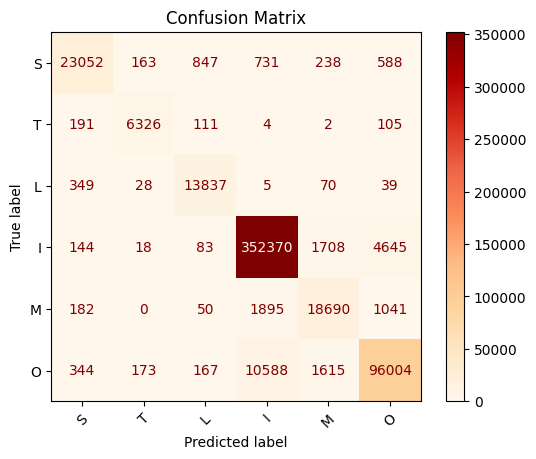

In [ ]:
# Evaluation

import matplotlib.pyplot as plt

model.eval()
val_loss = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        # Compute loss using CRF (pass labels)
        loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        val_loss += loss.item()

        # Decode predictions using CRF (no labels passed)
        predictions = model(input_ids=input_ids, attention_mask=attention_mask)  # List[List[int]]

        # Loop through batch and collect valid tokens
        for pred_seq, label_seq, mask in zip(predictions, labels, attention_mask):
            for pred, true, is_valid in zip(pred_seq, label_seq, mask):
                if true.item() != -100 and is_valid.item() == 1:
                    all_preds.append(pred)
                    all_labels.append(true.item())


# Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=list(label_map.keys())))

# Sequence Level Accuracy
seq_acc_val = sequence_level_accuracy(all_preds, all_labels, test_label_seqs)
print(f"Sequence Level Accuracy: {seq_acc_val:.4f}")

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(all_labels, all_preds)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds, labels=list(label_map.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.keys())
disp.plot(cmap="OrRd", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

writer.add_scalar("Loss/test", val_loss)

writer.flush()
writer.close()


In [30]:
import torch
from torchviz import make_dot
from torchview import draw_graph

# Load the model
model = SPCNNClassifier(encoder, NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load("/Users/jonas/Desktop/Uni/PBL/models/prot_bert_linear_classifier_v3.pt"))
model.eval()

# Create dummy inputs matching the expected dimensions
batch_size = 1
seq_length = 512  # maximum token length
dummy_input_ids = torch.randint(0, 1000, (batch_size, seq_length)).to(DEVICE)  
dummy_attention_mask = torch.ones((batch_size, seq_length), dtype=torch.long).to(DEVICE)
# Create dummy labels for the CRF loss computation; filling with -100 so that loss is computed correctly
dummy_labels = torch.full((batch_size, seq_length), -100, dtype=torch.long).to(DEVICE)

# Set the model to evaluation mode
model.eval()

# --- Visualization using torchviz ---
# Forward pass to compute a loss (required for torchviz to trace the graph)
dummy_loss = model(dummy_input_ids, dummy_attention_mask, dummy_labels)
dot = make_dot(dummy_loss, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('model_visualization_torchviz', view=False)  # Save the graph image without opening it automatically

# --- Visualization using torchview ---
# Draw and display the model graph (adjust parameters as needed)
draw_graph(model, input_size=(batch_size, seq_length), device=DEVICE)


KeyboardInterrupt: 